In [31]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from tqdm import tqdm
import copy

site = 'Pully_large_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian3' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
output_std = 0.1
input_std = 0.1
site_name2save = 'input_std_' + str(input_std) + '-output_std_' + str(output_std) 
path_model = os.path.join(pathsite, 'save', 'save_BERT4TRANSIT_{0}_'.format(site_name2save)+'no_c_'+algo+'.pth.tar')            

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 300

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, [lst_test[0]], BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]

if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian3':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

pQ_saved = np.zeros((len(lst_test),365*24))
CQ_saved = np.zeros((len(lst_test)))

saved_basis = copy.deepcopy(model.model.basis_values)

mode2param = {}
mode2opt = {}
mode2bound = {'low':0.975, 'up':0.975}


Cout_test = torch.zeros(len(lst_test))
CJ_test = torch.zeros((len(lst_test), Tmax))
J_test = torch.zeros((len(lst_test), Tmax))

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site,lst_test, BATCH_SIZE=len(lst_test))


for i,t in enumerate(lst_test):
    Cout_test[i] = Cout[t]
    CJ_test[i,:] = CJ[t-Tmax:t]
    J_test[i,:] = J[t-Tmax:t]


with torch.no_grad():
    for mode in ['low','up']:
        mode2param[mode] = 1 
        mode2opt[mode] = 1
        found = False
        ini_step = True
        model.model.basis_values = copy.deepcopy(saved_basis)
        
    
        if algo=='Ispline':
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo=='AgeDomain':
            Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
        elif algo in ['SumSquares_noBERT2_bayesian3']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)

        Chat = np.array(Chat)
        Cout_test = np.array(Cout_test)
        Chat_saved = copy.deepcopy(Chat)
        found = False
        ini_step = True
        tau = 0.01
        while not(found):
            if ini_step:
                ini_step = False
                if mode=='low':
                    prop = np.mean((Cout_test - Chat)>=0)
                    if (prop >= mode2bound[mode]):
                        mode2param[mode] = 1-tau
                    else:
                        mode2param[mode] = 1+tau
                else:
                    prop = np.mean((Chat-Cout_test)>=0)
                    if (prop >= mode2bound[mode]):
                        mode2param[mode] = 1+tau
                    else:
                        mode2param[mode] = 1-tau
            prop = np.mean((Cout_test - Chat)>=0)
            print(mode, prop)
            if mode=='low':
                if (prop >= mode2bound[mode]):
                    if (mode2param[mode]<1):
                        mode2opt[mode] *= mode2param[mode]
                        Chat = mode2opt[mode] * Chat_saved
                    else:
                        found = True
                else:
                    if (mode2param[mode]>1):
                        mode2opt[mode] *= mode2param[mode]
                        Chat = mode2opt[mode] * Chat_saved
                    else:
                        found = True
            else:
                prop = np.mean((Chat-Cout_test)>=0)
                if (prop >= mode2bound[mode]):
                    if (mode2param[mode]>1):
                        mode2opt[mode] *= mode2param[mode]
                        Chat = mode2opt[mode] * Chat_saved
                    else:
                        found = True
                else:
                    if (mode2param[mode]<1):
                        mode2opt[mode] *= mode2param[mode]
                        Chat = mode2opt[mode] * Chat_saved
                    else:
                        found = True

low 0.056666666666666664
low 0.5566666666666666
low 0.9033333333333333
low 0.95
low 0.9766666666666667
up 0.056666666666666664
up 0.02


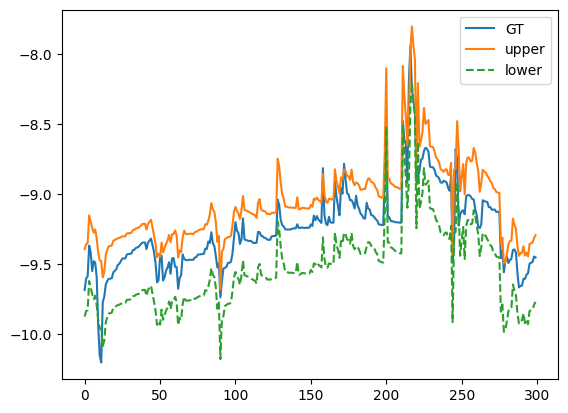

In [32]:
plt.plot(Cout_test, label='GT')
plt.plot(Chat_saved*mode2opt['up'], label='upper')
plt.plot(Chat_saved*mode2opt['low'], linestyle='--', label='lower')
plt.legend()

In [33]:
npy_file = os.path.join(pathsite_ground_truth, 'TTD.npy')
ttds = np.load(npy_file)
# keeping relevant ground truth values
rows_to_load = lst_test - (len(CJ)-ttds.shape[0])

idxs2keep_true_ttd = lst_test - (len(CJ)-ttds.shape[0])
ttds_true = ttds[idxs2keep_true_ttd,:]
ywf_true = np.cumsum(ttds_true, axis=1)[:,[24*30*j for j in range(1,10)]]
print('True TTDs loaded')

True TTDs loaded


In [34]:
maxT = 365*24
pQlow = np.cumsum( np.mean(np.array(pQ)[:,:maxT], axis=0)) * mode2opt['low']
pQup = np.cumsum( np.mean(np.array(pQ)[:,:maxT], axis=0)) * mode2opt['up']

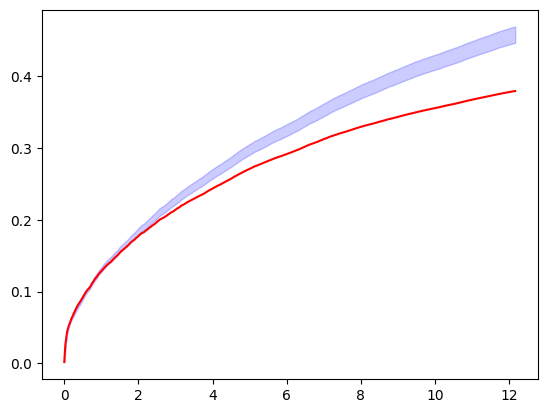

In [35]:
x = np.arange(maxT)/(24*30)
plt.fill_between(x, pQlow, pQup, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(x, np.cumsum(np.mean(ttds_true[:,:maxT], axis=0)), label='True TTD', color='red')

In [36]:
mode2opt

{'low': 1.04060401, 'up': 0.99}

In [30]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from tqdm import tqdm
import copy

site = 'Pully_large_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian3' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
output_std = 0.1
input_std = 0.1
site_name2save = 'input_std_' + str(input_std) + '-output_std_' + str(output_std) 
path_model = os.path.join(pathsite, 'save', 'save_BERT4TRANSIT_{0}_'.format(site_name2save)+'no_c_'+algo+'.pth.tar')            

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 300

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, [lst_test[0]], BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]

if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian3':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

pQ_saved = np.zeros((len(lst_test),365*24))
CQ_saved = np.zeros((len(lst_test)))

saved_basis = copy.deepcopy(model.model.basis_values)

mode2param = {}
mode2opt = {}
mode2bound = {'low':0.975, 'up':0.975}


Cout_test = torch.zeros(len(lst_test))
CJ_test = torch.zeros((len(lst_test), Tmax))
J_test = torch.zeros((len(lst_test), Tmax))

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site,lst_test, BATCH_SIZE=len(lst_test))


for i,t in enumerate(lst_test):
    Cout_test[i] = Cout[t]
    CJ_test[i,:] = CJ[t-Tmax:t]
    J_test[i,:] = J[t-Tmax:t]


with torch.no_grad():
    for mode in ['low','up']:
        mode2param[mode] = 1 
        mode2opt[mode] = 1
        found = False
        ini_step = True
        model.model.basis_values = copy.deepcopy(saved_basis)
        while not(found):
            
        
            if algo=='Ispline':
                Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            elif algo=='AgeDomain':
                Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
                Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
                w = model.model.forward_w(data_test)
                w = w.detach().numpy()
                frac_year = timeyear_test
                frac_year = [el-int(el) for el in frac_year]
                frac_year = np.array([min([1-el, el]) for el in frac_year])
                winter_idxs = np.where(frac_year<=(2*30/365))[0]
                summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
                w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
                w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
        
            elif algo in ['SumSquares_noBERT2_bayesian3']:
                Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
                w = model.model.forward_w(data_test)
                w = w.detach().numpy()
                frac_year = timeyear_test
                frac_year = [el-int(el) for el in frac_year]
                frac_year = np.array([min([1-el, el]) for el in frac_year])
                winter_idxs = np.where(frac_year<=(2*30/365))[0]
                summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
                w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
                w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)

            Chat = np.array(Chat)
            Cout_test = np.array(Cout_test)
            if ini_step:
                ini_step = False
                if mode==['low']:
                    prop = np.mean((Cout_test - Chat)>=0)
                    if (prop >= mode2bound[mode]):
                        mode2param[mode] = 1.5
                    else:
                        mode2param[mode] = 0.5
                else:
                    prop = np.mean((Chat-Cout_test)>=0)
                    if (prop >= mode2bound[mode]):
                        mode2param[mode] = 0.5
                    else:
                        mode2param[mode] = 1.5
            prop = np.mean((Cout_test - Chat)>=0)
            print(mode, prop)
            if mode==['low']:
                if (prop >= mode2bound[mode]):
                    if (mode2param[mode]<1):
                        mode2opt[mode] *= mode2param[mode]
                        model.model.basis_values = mode2opt[mode] * copy.deepcopy(saved_basis)
                    else:
                        found = True
                else:
                    if (mode2param[mode]>1):
                        mode2opt[mode] *= mode2param[mode]
                        model.model.basis_values = mode2opt[mode] * copy.deepcopy(saved_basis)
                    else:
                        found = True
            else:
                prop = np.mean((Chat-Cout_test)>=0)
                if (prop >= mode2bound[mode]):
                    if (mode2param[mode]<1):
                        mode2opt[mode] *= mode2param[mode]
                        model.model.basis_values = mode2opt[mode] * copy.deepcopy(saved_basis)
                    else:
                        found = True
                else:
                    if (mode2param[mode]>1):
                        mode2opt[mode] *= mode2param[mode]
                        model.model.basis_values = mode2opt[mode] * copy.deepcopy(saved_basis)
                    else:
                        found = True

low 0.056666666666666664


KeyboardInterrupt: 

In [38]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from tqdm import tqdm

site = 'Pully_small_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian3' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
output_std = 0.1
input_std = 0.1
site_name2save = 'input_std_' + str(input_std) + '-output_std_' + str(output_std) 
path_model = os.path.join(pathsite, 'save', 'save_BERT4TRANSIT_{0}_'.format(site_name2save)+'no_c_'+algo+'.pth.tar')            

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 300

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, [lst_test[0]], BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]

if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian3':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

n_samples = 200
pQ_saved = np.zeros((n_samples,len(lst_test),365*24))
CQ_saved = np.zeros((n_samples,len(lst_test)))


ngroups = 10
for k in tqdm(range(ngroups)):
    indexes = np.array([i for i in range(k*int(BATCH_SIZE/ngroups),(k+1)*int(BATCH_SIZE/ngroups))]).astype(int)
    lst_test_temp = lst_test[indexes]
    with torch.no_grad():            
        Cout_test = torch.zeros(len(lst_test_temp))
        CJ_test = torch.zeros((len(lst_test_temp), Tmax))
        J_test = torch.zeros((len(lst_test_temp), Tmax))

        data_test, timeyear_test = WT.get_data_noBERT(pathsite, site,lst_test_temp, BATCH_SIZE=len(lst_test_temp))

    
        for i,t in enumerate(lst_test_temp):
            Cout_test[i] = Cout[t]
            CJ_test[i,:] = CJ[t-Tmax:t]
            J_test[i,:] = J[t-Tmax:t]
    
        if algo=='Ispline':
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo=='AgeDomain':
            Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
        elif algo in ['SumSquares_noBERT2_bayesian3']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
            Chat_uncertainty, pQ_uncertainty = WT.get_uncertainties(data_test, J_test, CJ_test, n_samples=n_samples)
            CQ_saved[:,indexes] = Chat_uncertainty
    
            start_index = (WT.path_model).find("BERT4TRANSIT")
            name_model = WT.path_model[start_index:-8] # -8 to remove '.pth.tar'

            pQ_saved[:,indexes,:] = pQ_uncertainty[:,:,:pQ_saved.shape[-1]]
    
            print(pQ_uncertainty.shape)
            filename = os.path.join(pathsite, 'save', "pQ_uncertainties_dirichlet_{0}.npy".format(name_model))
            #np.save(filename, pQ_uncertainty) 
            print('Uncertainties computed')            

  0% 0/10 [00:00<?, ?it/s]/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
  0% 0/10 [00:09<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/save/params_uncertainties_BERT4TRANSIT_input_std_0.1-output_std_0.1_no_c_SumSquares_noBERT2_bayesian3.pkl'

In [6]:
npy_file = os.path.join(pathsite_ground_truth, 'TTD.npy')
ttds = np.load(npy_file)
# keeping relevant ground truth values
rows_to_load = lst_test - (len(CJ)-ttds.shape[0])

idxs2keep_true_ttd = lst_test - (len(CJ)-ttds.shape[0])
ttds_true = ttds[idxs2keep_true_ttd,:]
ywf_true = np.cumsum(ttds_true, axis=1)[:,[24*30*j for j in range(1,10)]]
print('True TTDs loaded')

True TTDs loaded


In [16]:
maxT = 365*24
pQlow = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 0, axis=0)
pQup = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 100, axis=0)

if True:
    pQlow = np.zeros(maxT)
    pQup = np.zeros(maxT)
    for i in range(pQ_saved.shape[1]):
        pQlow += np.percentile(np.cumsum( pQ_saved[:,i,:maxT], axis=1), 100*threshold, axis=0) / pQ_saved.shape[1]
        pQup += np.percentile(np.cumsum( pQ_saved[:,i,:maxT], axis=1), (1-threshold)*100, axis=0) / pQ_saved.shape[1]

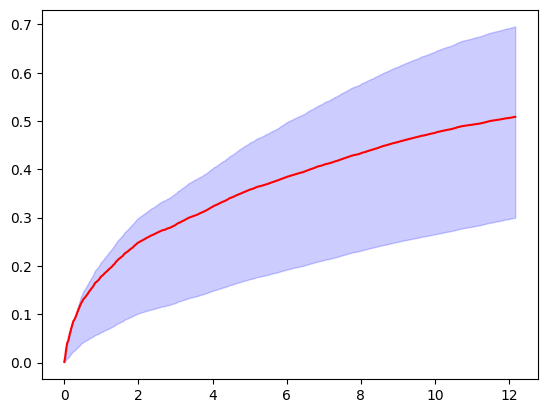

In [17]:
x = np.arange(maxT)/(24*30)
plt.fill_between(x, pQlow, pQup, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(x, np.cumsum(np.mean(ttds_true[:,:maxT], axis=0)), label='True TTD', color='red')

In [ ]:
Cout_test = Cout[lst_test]
CQlow = np.percentile(CQ_saved, 5, axis=0)
CQup = np.percentile(CQ_saved, 95, axis=0)
plt.fill_between(lst_test, CQlow, CQup, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(lst_test, Cout_test, label='Observed tracer', color='red')

In [8]:
start_index = WT.path_model.find("BERT4TRANSIT")
name_model = WT.path_model[start_index:-8]
filename = os.path.join(WT.pathsite, 'save', f"params_uncertainties_dirchlet_{name_model}.pkl")



with open(filename, 'rb') as handle:
    params_svi = pickle.load(handle)

for key, value in params_svi.items():
    params_svi[key] = torch.tensor(value)

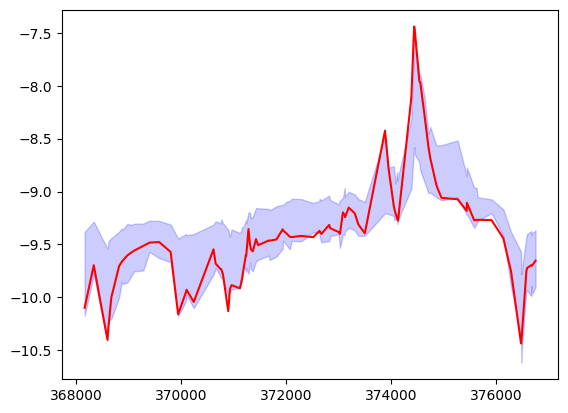

In [14]:
threshold = 0.4
found = False
while not(found):
    Cout_test = np.array(Cout[lst_test])
    CQlow = np.percentile(CQ_saved, threshold*100, axis=0)
    CQup = np.percentile(CQ_saved, (1-threshold)*100, axis=0)
    threshold -= 0.01
    found = (np.mean( (CQlow<=Cout_test) & (Cout_test<=CQup))>0.80)
plt.fill_between(lst_test, CQlow, CQup, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot(lst_test, Cout_test, label='Observed tracer', color='red')

In [3]:
threshold

0.019999999999999803

In [1]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from tqdm import tqdm

site = 'Pully_small_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian3' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
path_model = os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_no_c_{algo}.pth.tar')

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 100

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, [lst_test[0]], BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]

if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian3':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

n_samples = 200
pQ_saved = np.zeros((n_samples,len(lst_test),365*24))


ngroups = 10
for k in tqdm(range(ngroups)):
    indexes = np.array([i for i in range(k*int(BATCH_SIZE/ngroups),(k+1)*int(BATCH_SIZE/ngroups))]).astype(int)
    lst_test_temp = lst_test[indexes]
    with torch.no_grad():            
        Cout_test = torch.zeros(len(lst_test_temp))
        CJ_test = torch.zeros((len(lst_test_temp), Tmax))
        J_test = torch.zeros((len(lst_test_temp), Tmax))

        data_test, timeyear_test = WT.get_data_noBERT(pathsite, site,lst_test_temp, BATCH_SIZE=len(lst_test_temp))

    
        for i,t in enumerate(lst_test_temp):
            Cout_test[i] = Cout[t]
            CJ_test[i,:] = CJ[t-Tmax:t]
            J_test[i,:] = J[t-Tmax:t]
    
        if algo=='Ispline':
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo=='AgeDomain':
            Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
        elif algo in ['SumSquares_noBERT2_bayesian3']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
            Chat_uncertainty, pQ_uncertainty = WT.get_uncertainties(data_test, J_test, CJ_test, n_samples=n_samples)
            Chat_uncertainty = Chat_uncertainty
    
            start_index = (WT.path_model).find("BERT4TRANSIT")
            name_model = WT.path_model[start_index:-8] # -8 to remove '.pth.tar'

            pQ_saved[:,indexes,:] = pQ_uncertainty[:,:,:pQ_saved.shape[-1]]
    
            print(pQ_uncertainty.shape)
            filename = os.path.join(pathsite, 'save', "pQ_uncertainties_{0}.npy".format(name_model))
            #np.save(filename, pQ_uncertainty) 
            print('Uncertainties computed')            

  0% 0/10 [00:00<?, ?it/s]/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 10% 1/10 [00:19<02:51, 19.04s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 20% 2/10 [00:38<02:33, 19.20s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 30% 3/10 [00:57<02:12, 18.96s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 40% 4/10 [01:14<01:51, 18.57s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 50% 5/10 [01:32<01:31, 18.23s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 60% 6/10 [01:50<01:12, 18.15s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 70% 7/10 [02:09<00:54, 18.33s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 80% 8/10 [02:28<00:36, 18.49s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 90% 9/10 [02:48<00:19, 19.02s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100% 10/10 [03:06<00:00, 18.62s/it]

torch.Size([200, 10, 43200])
Uncertainties computed


In [2]:
rows_to_load = lst_test - (len(CJ)-365*24*2)
npy_file = os.path.join(pathsite_ground_truth, 'TTD.npy')
ttds = np.load(npy_file)
# keeping relevant ground truth values
idxs2keep_true_ttd = lst_test - (len(CJ)-ttds.shape[0])
ttds_true = ttds[idxs2keep_true_ttd,:]
ywf_true = np.cumsum(ttds_true, axis=1)[:,[24*30*j for j in range(1,10)]]
print('True TTDs loaded')

True TTDs loaded


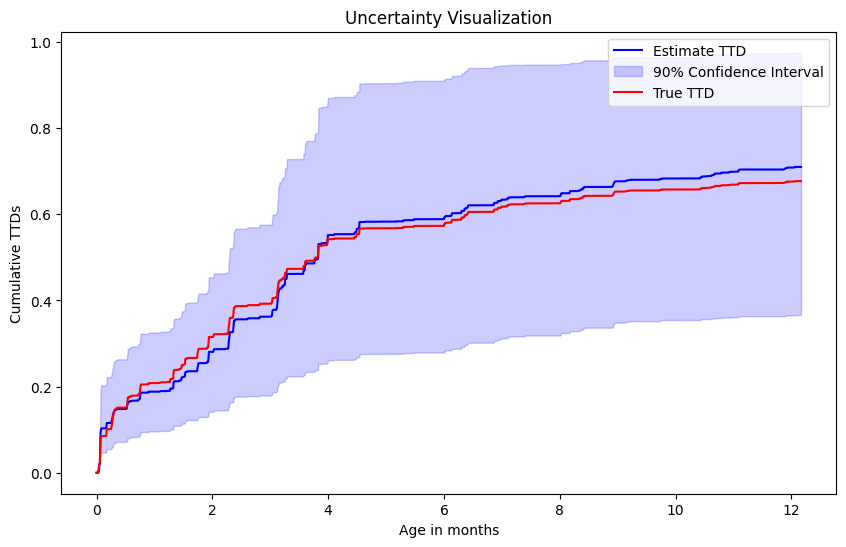

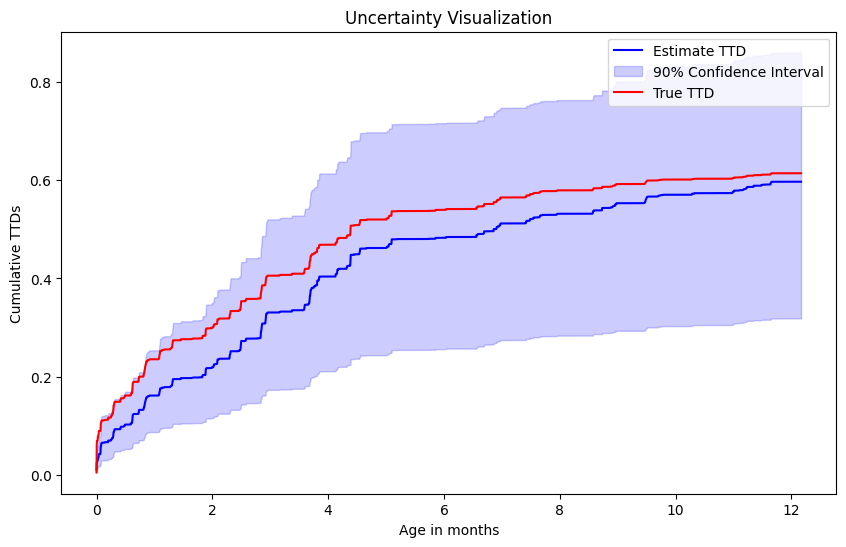

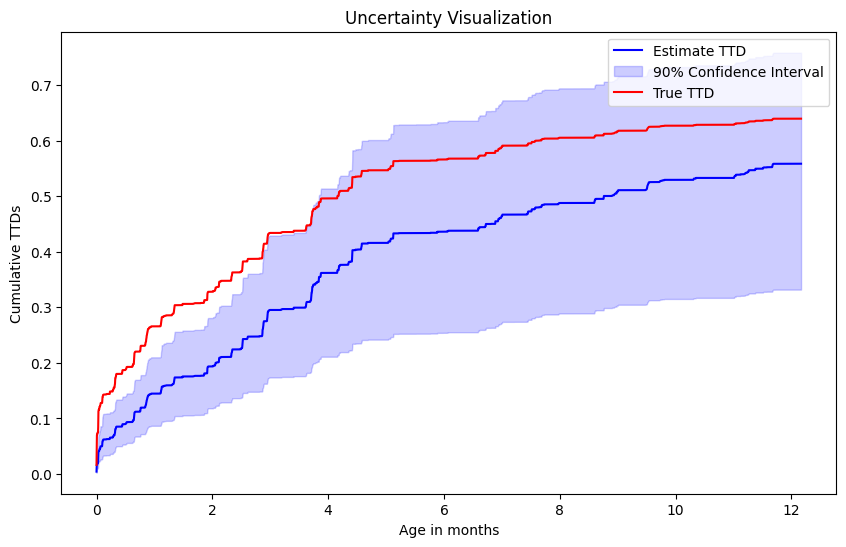

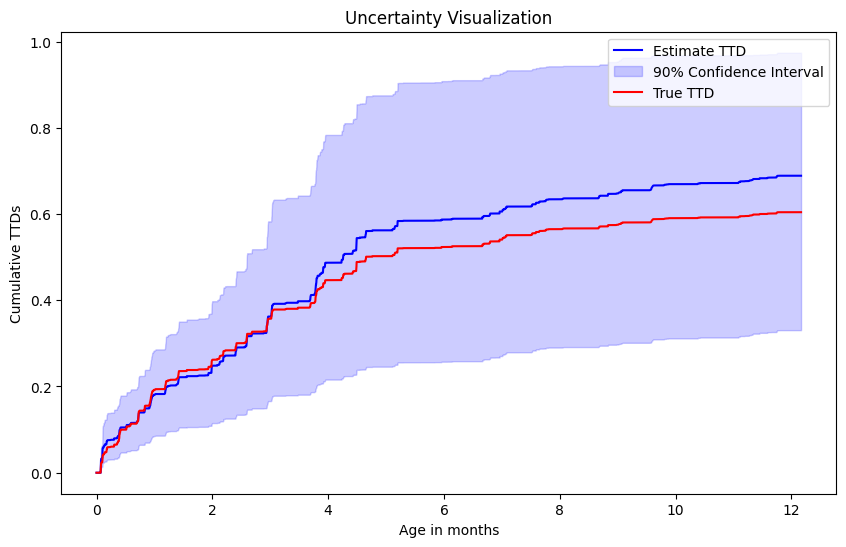

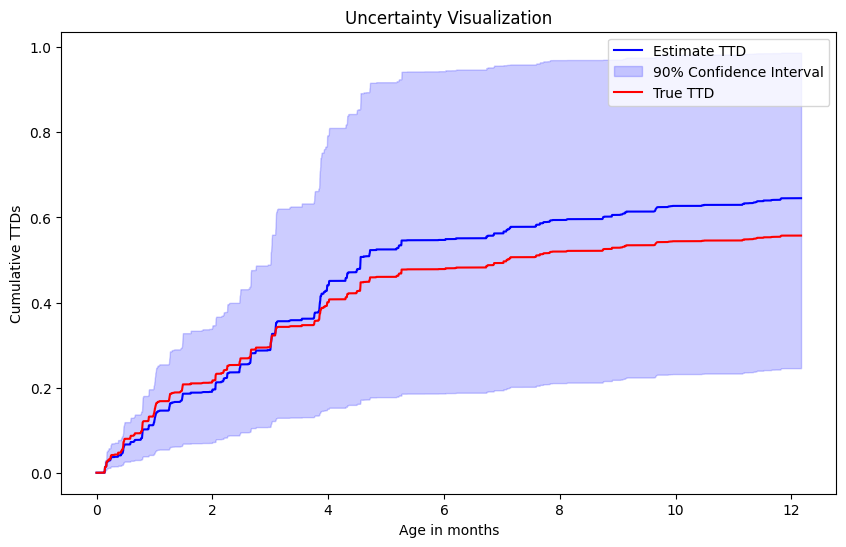

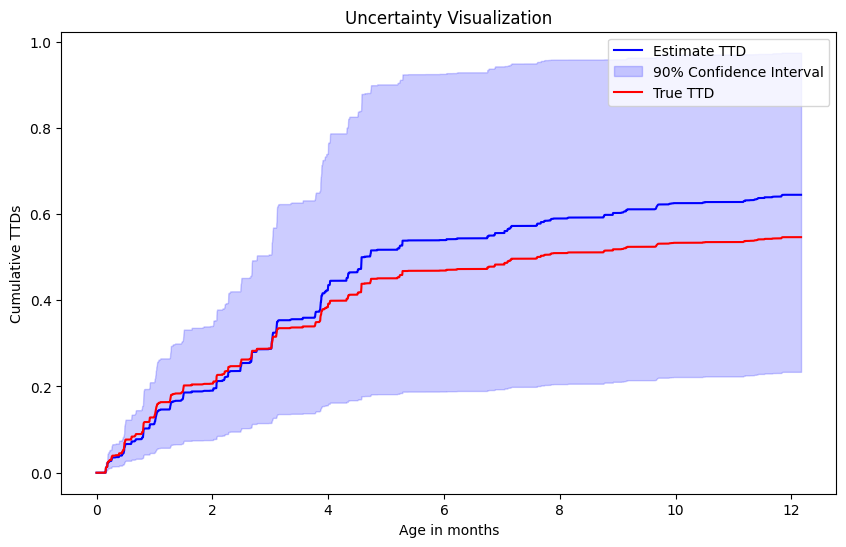

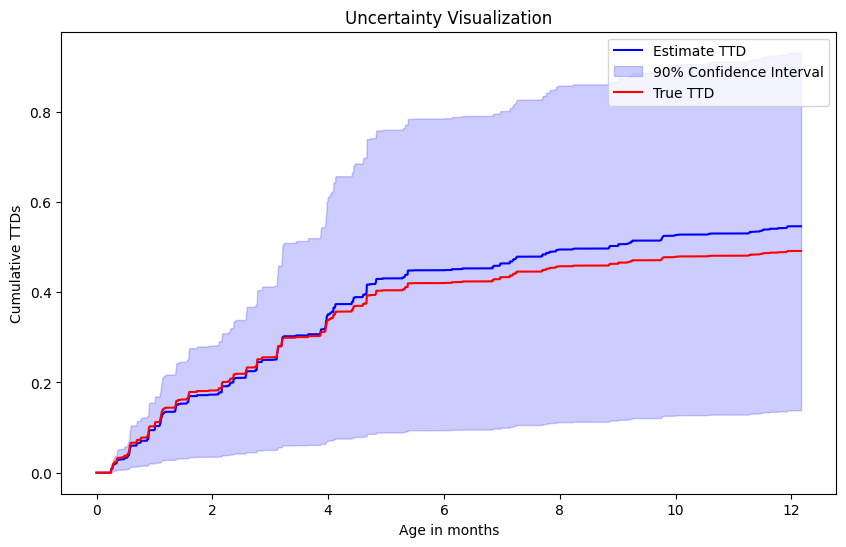

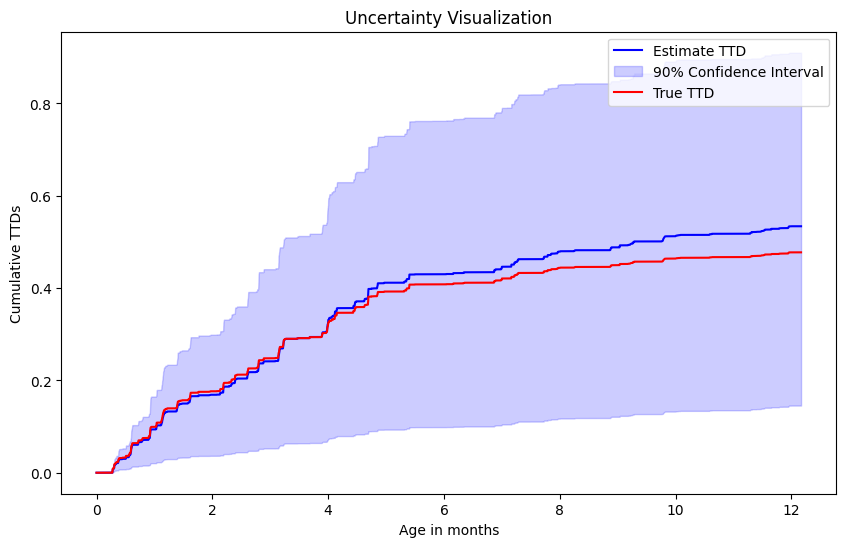

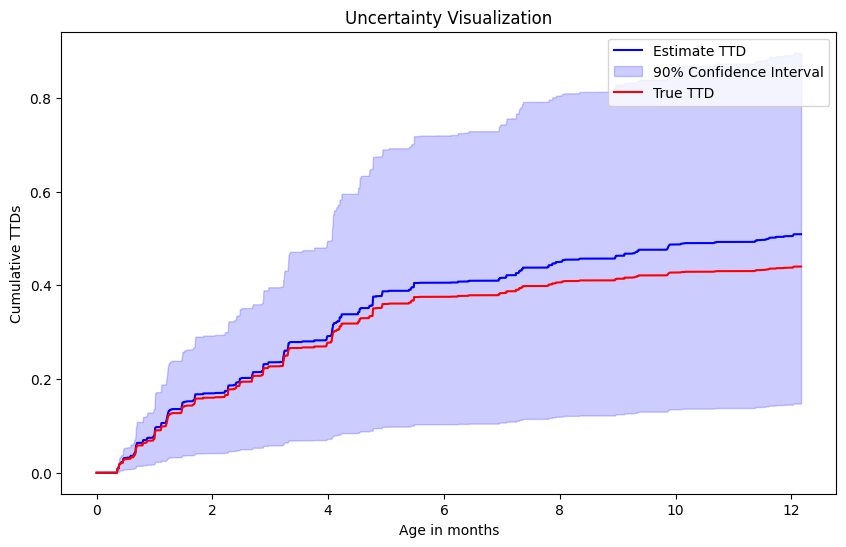

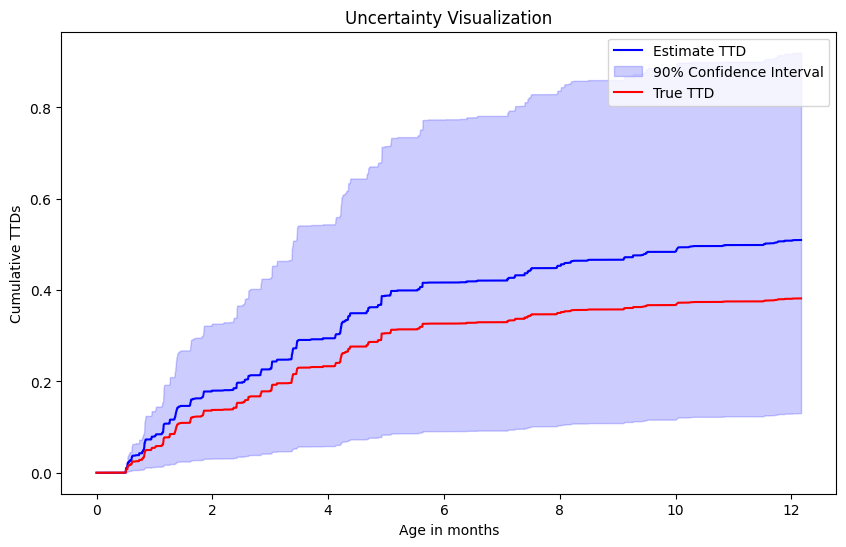

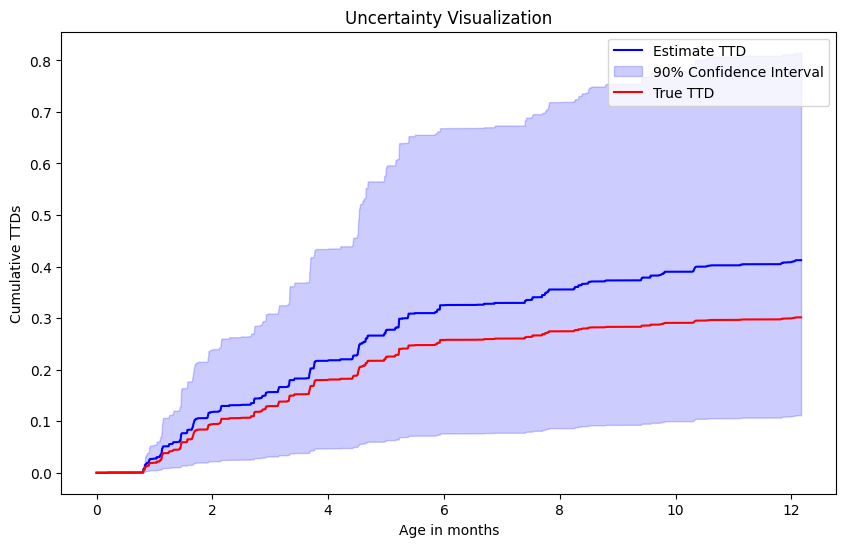

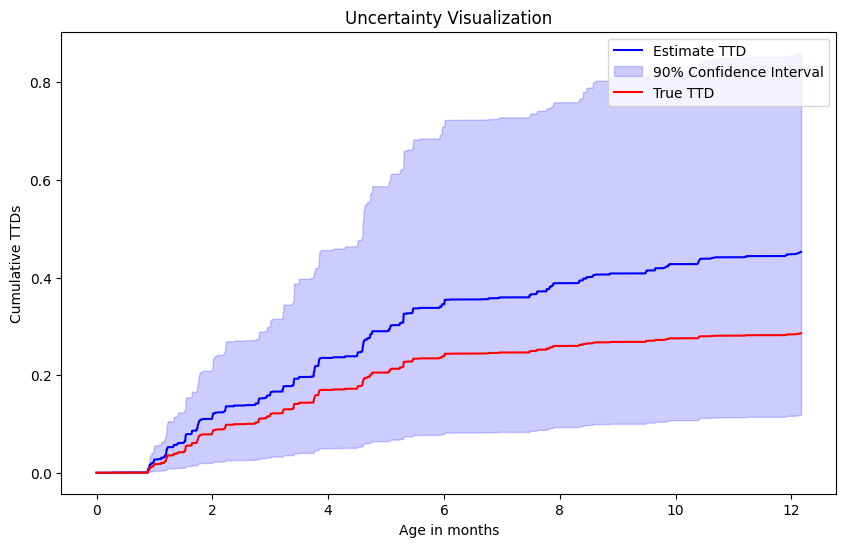

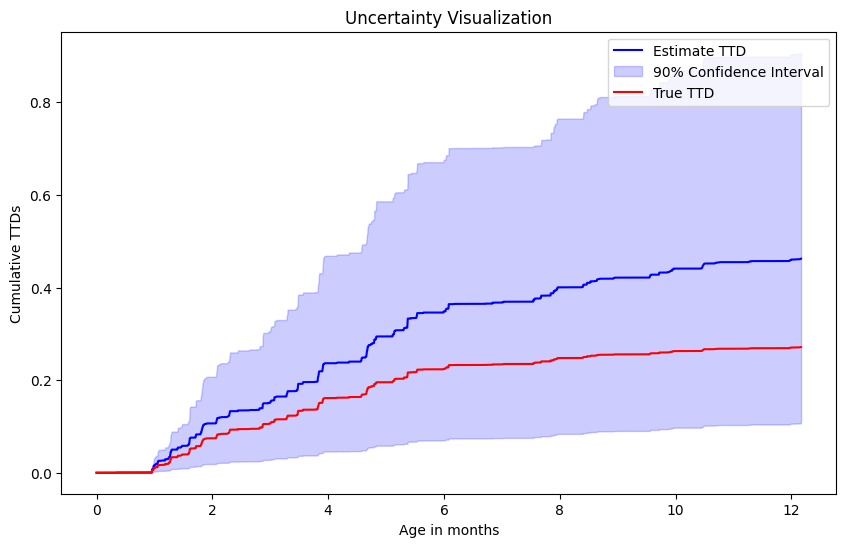

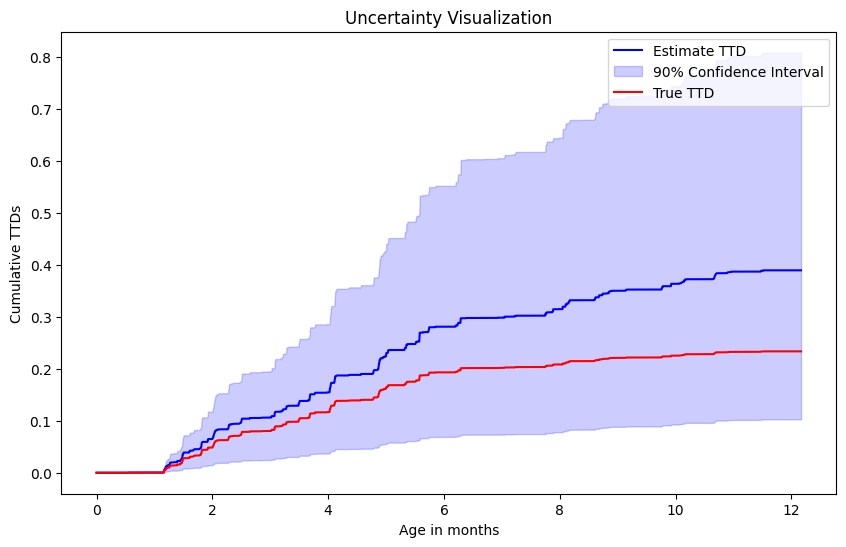

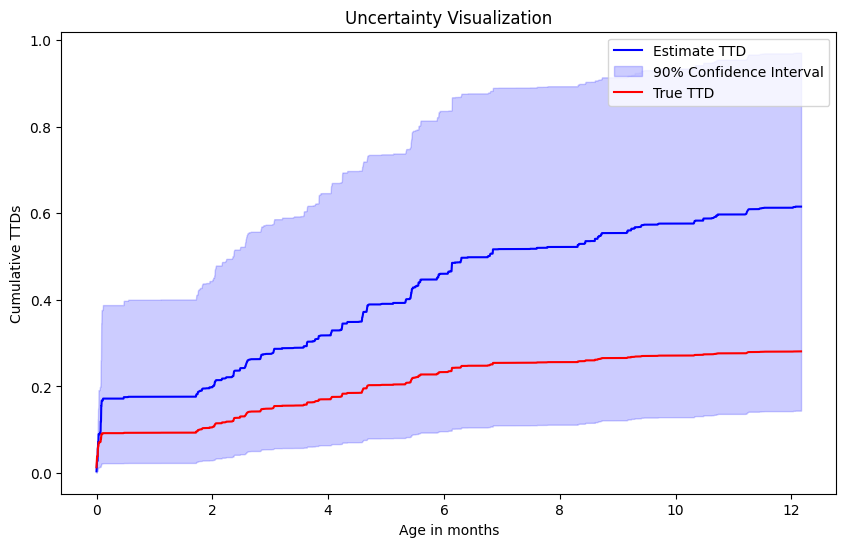

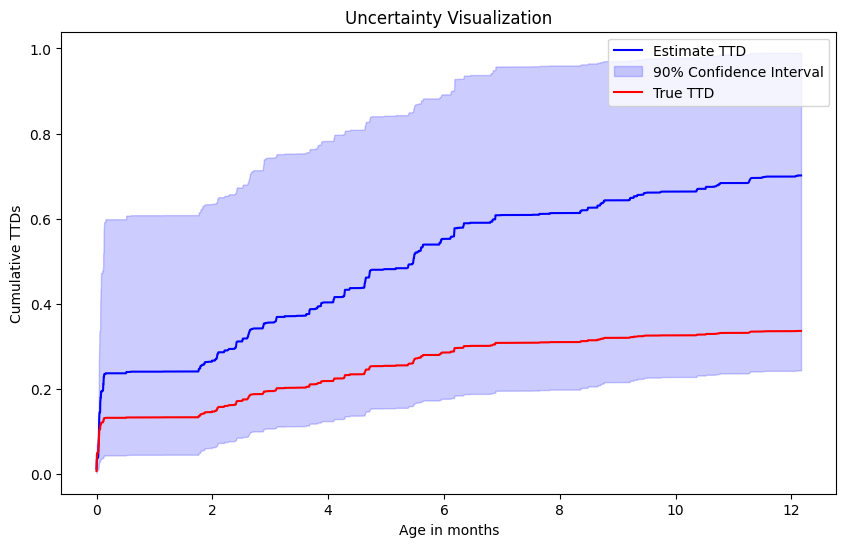

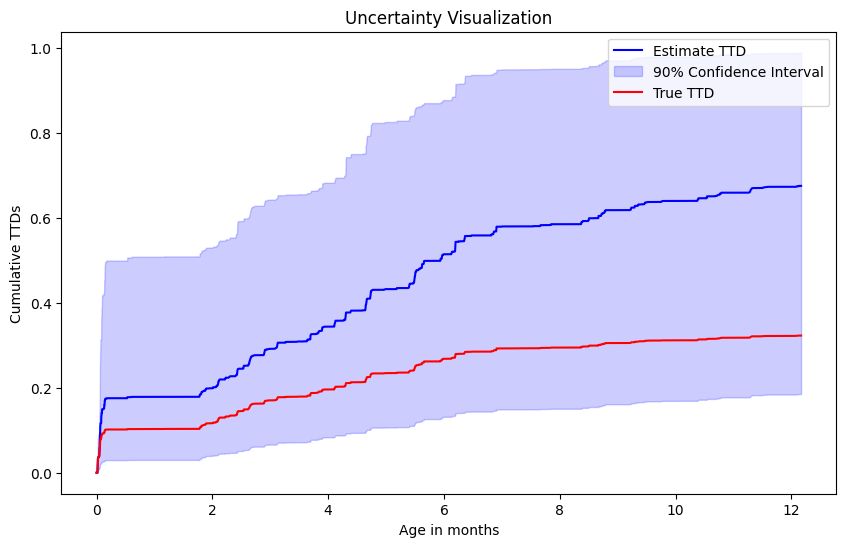

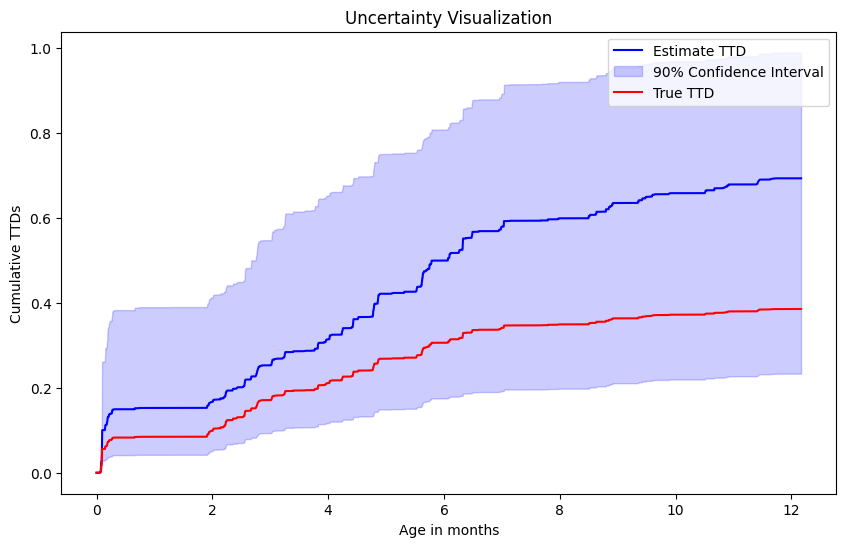

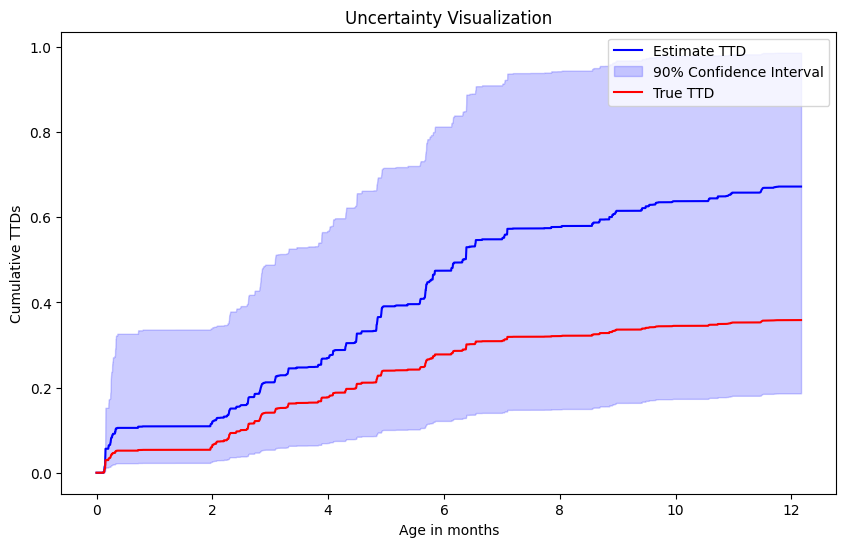

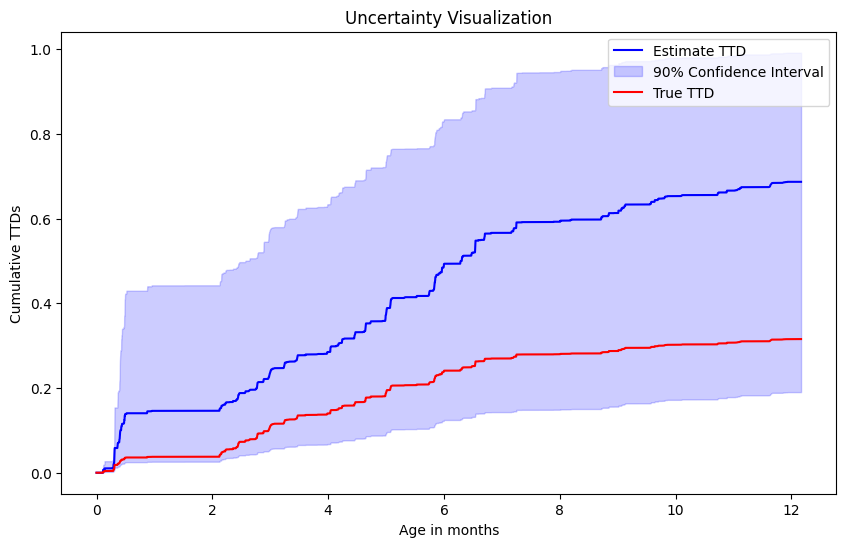

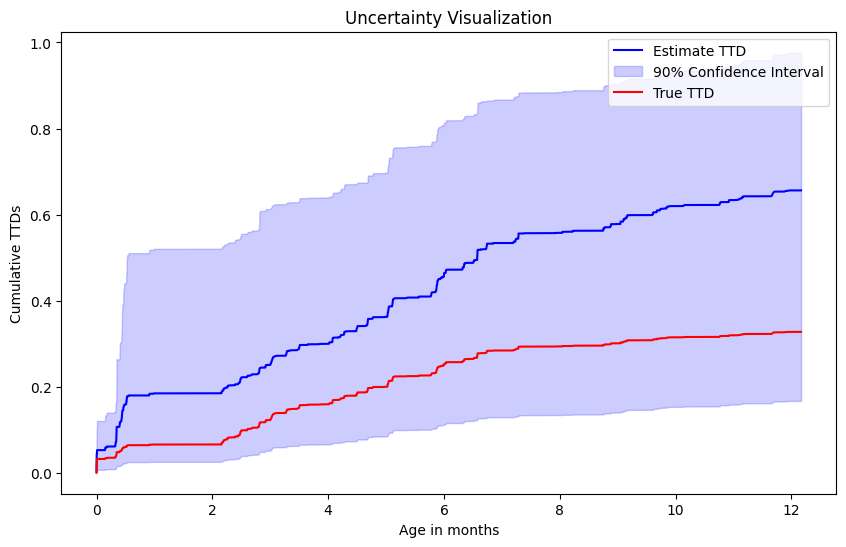

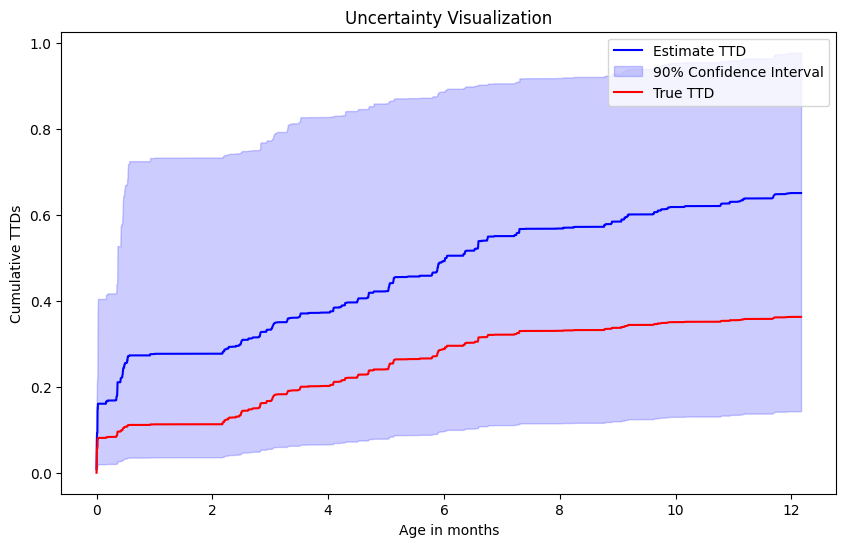

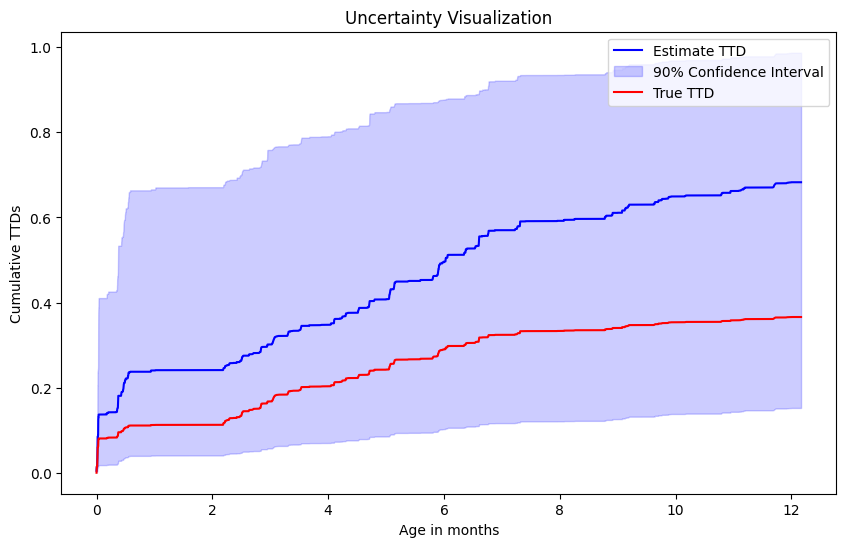

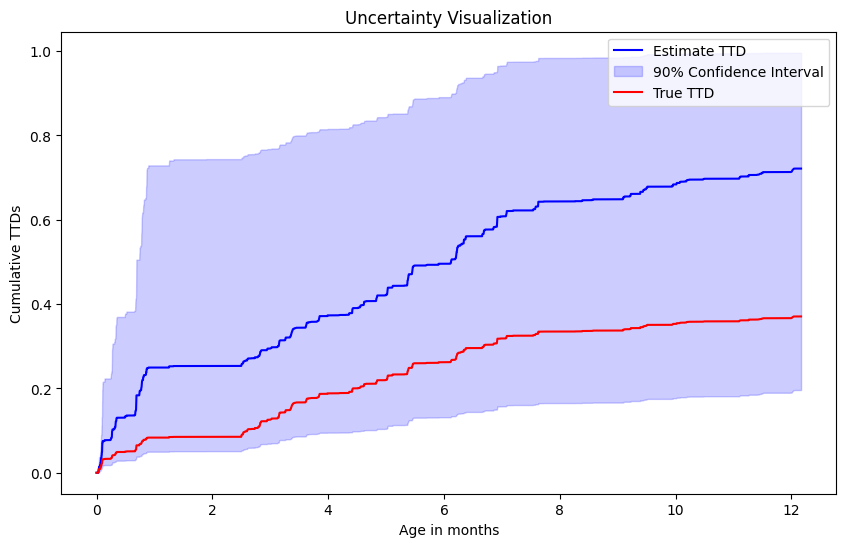

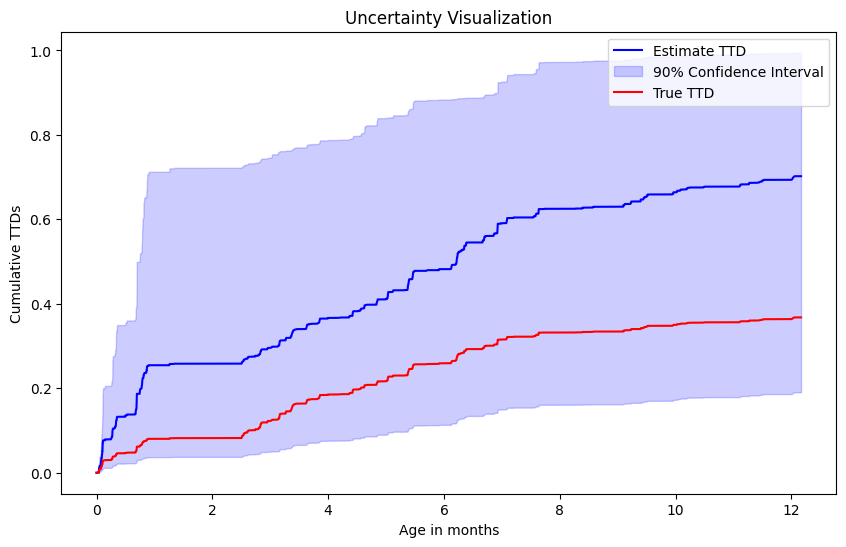

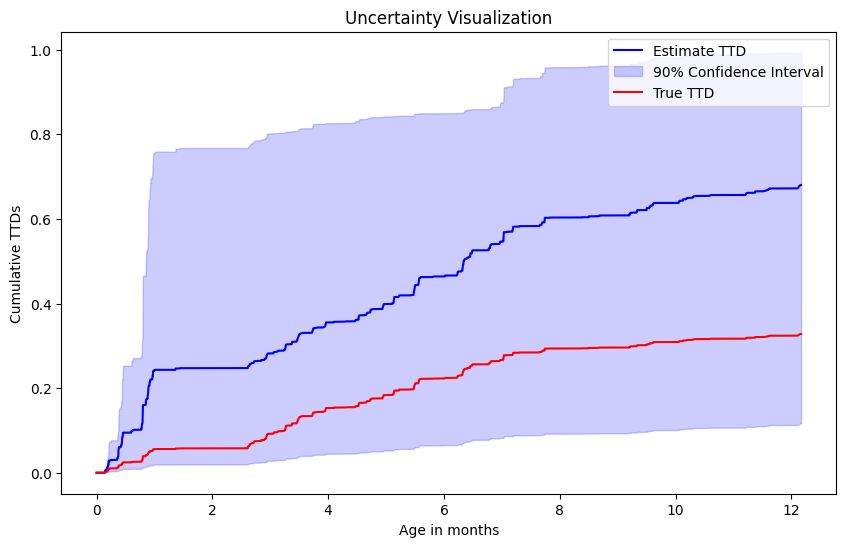

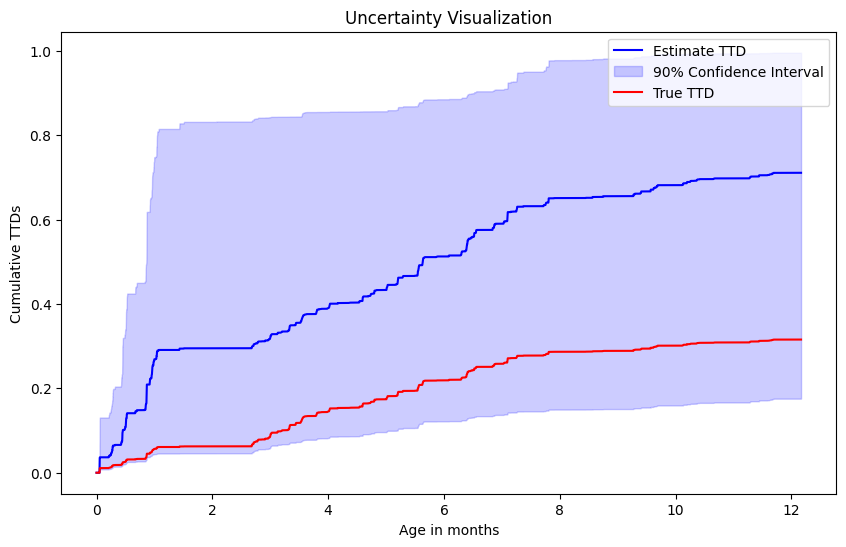

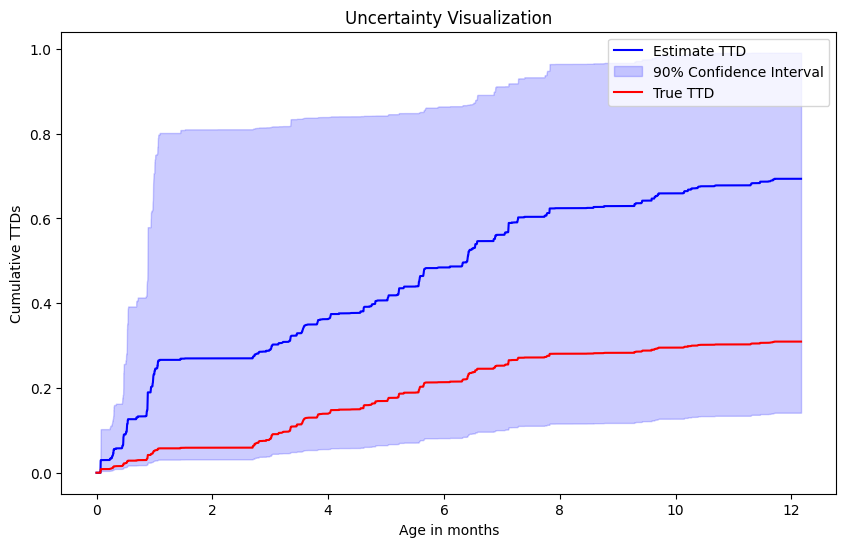

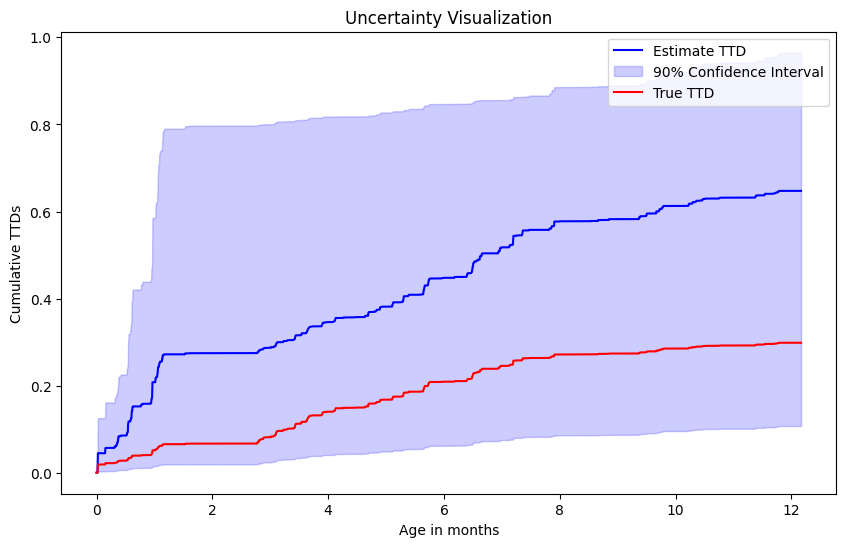

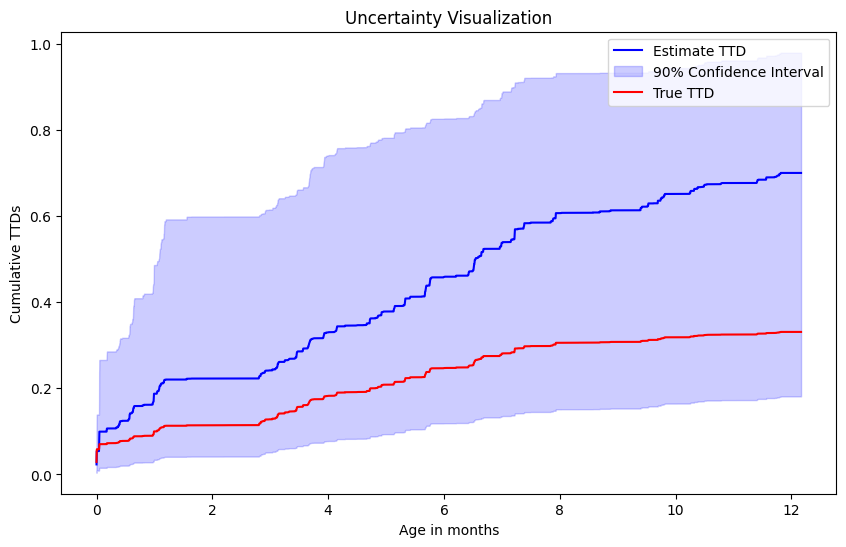

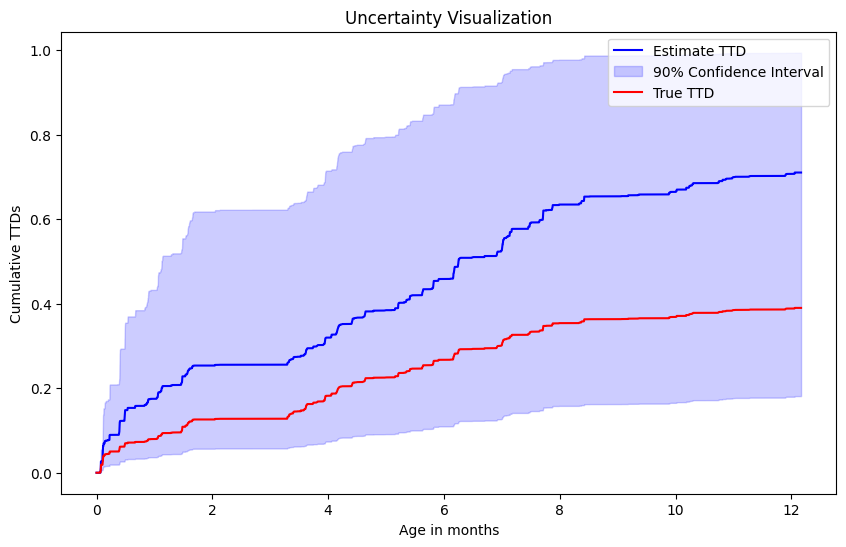

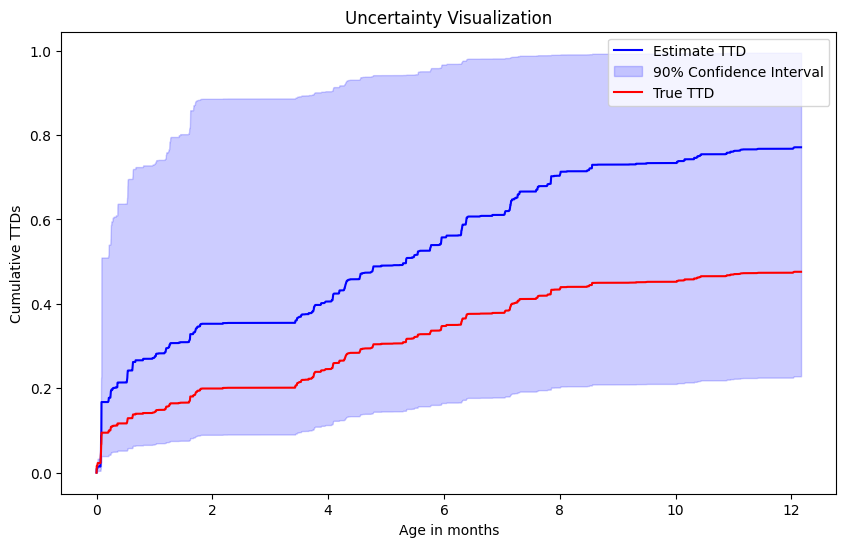

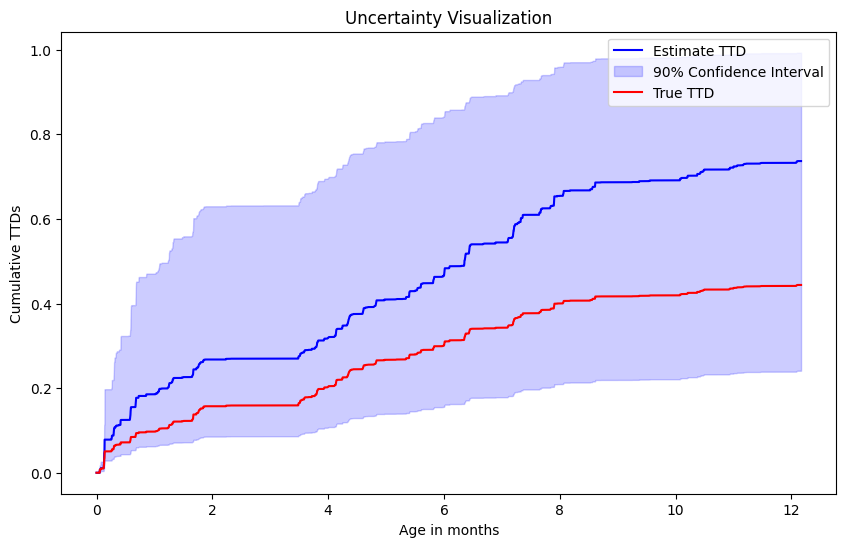

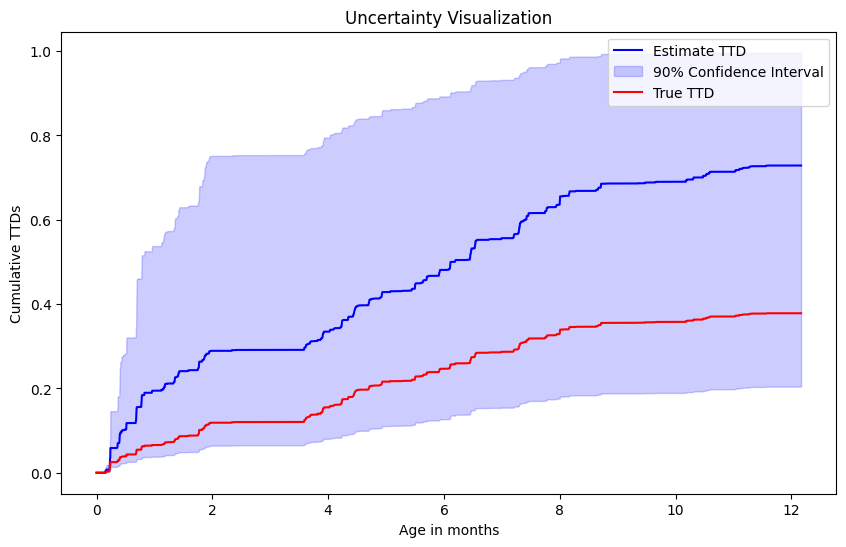

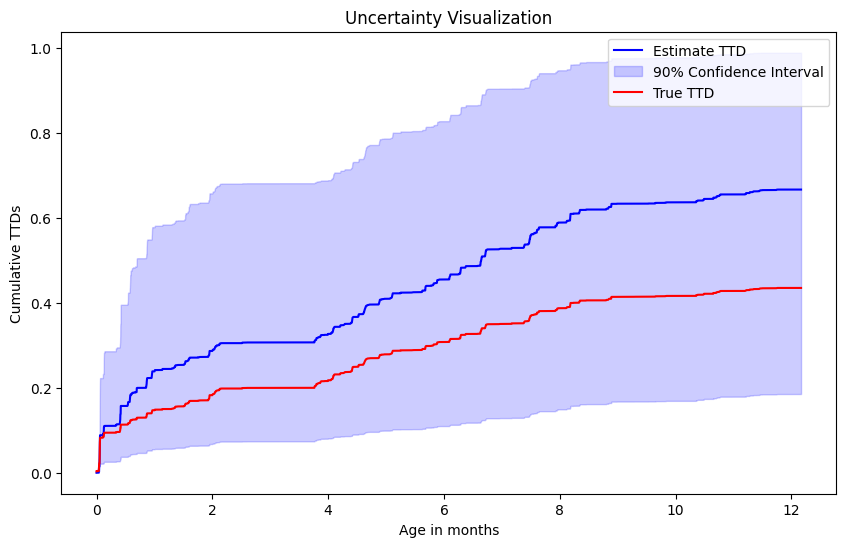

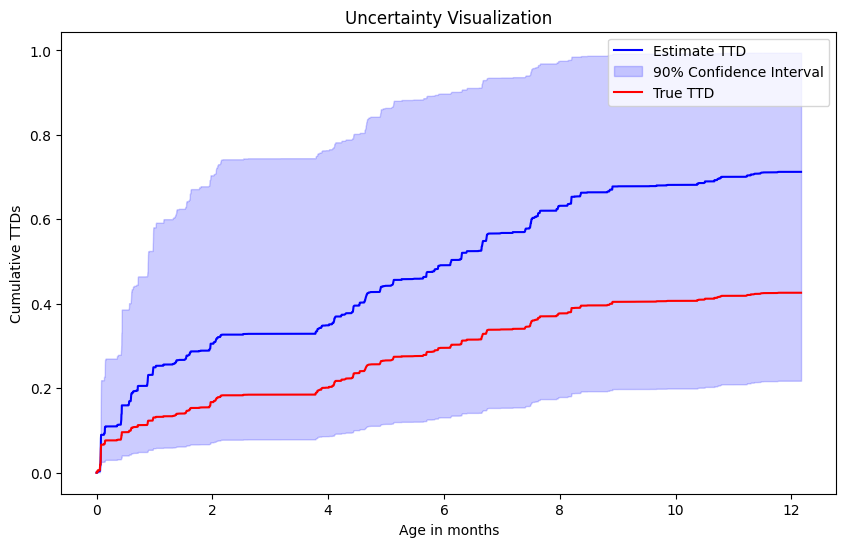

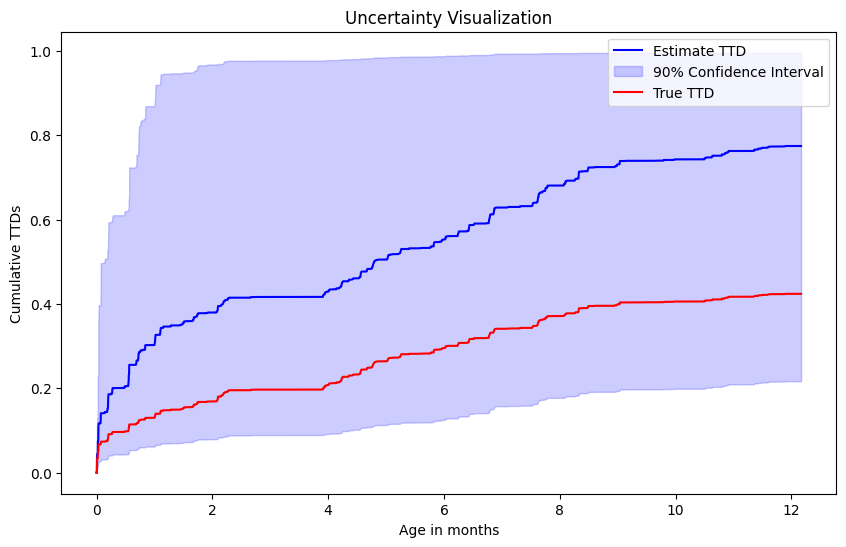

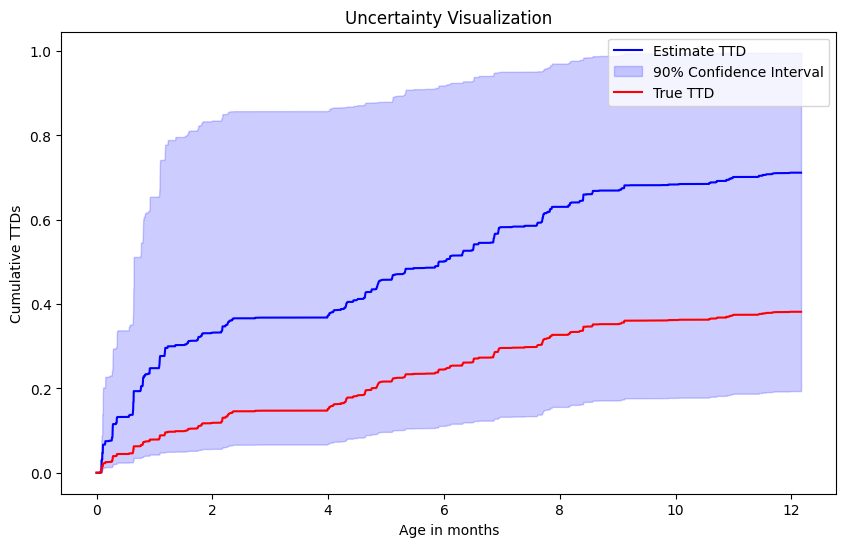

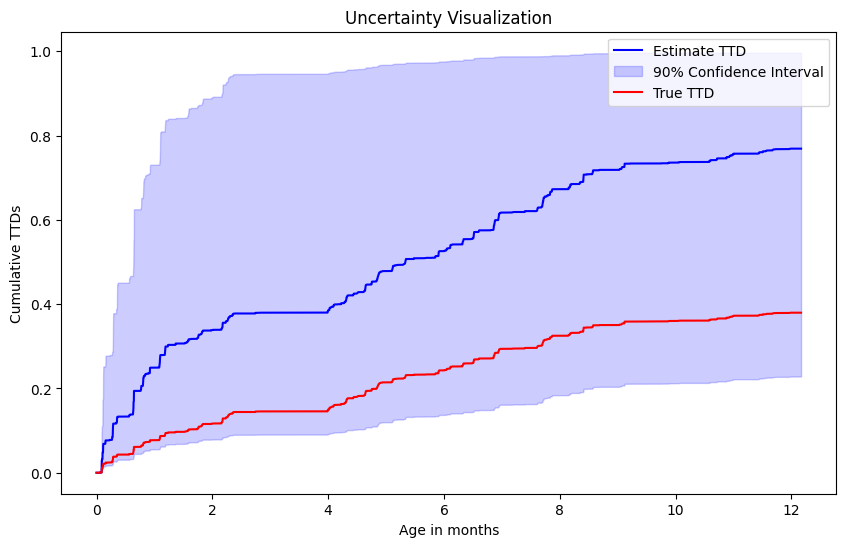

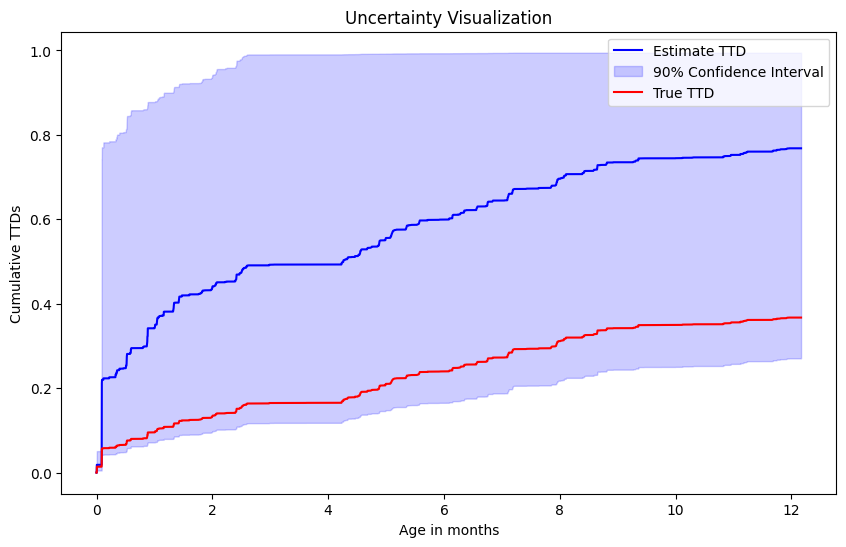

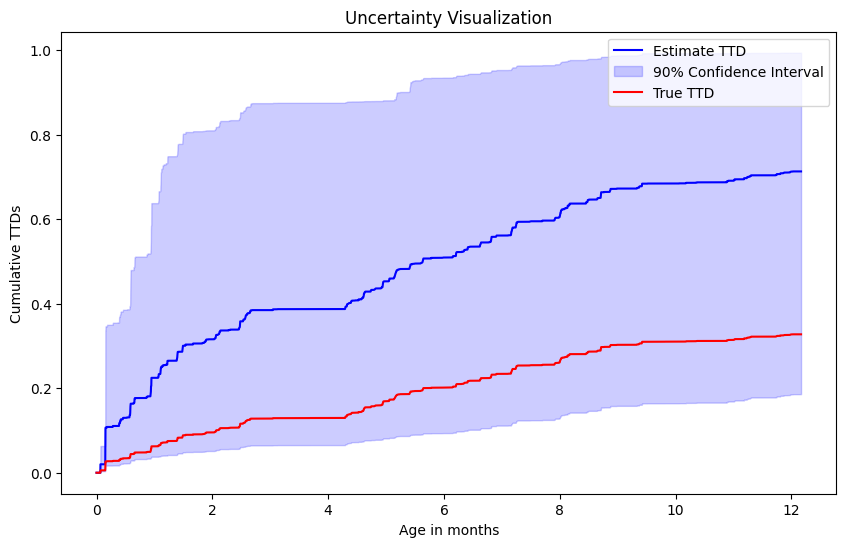

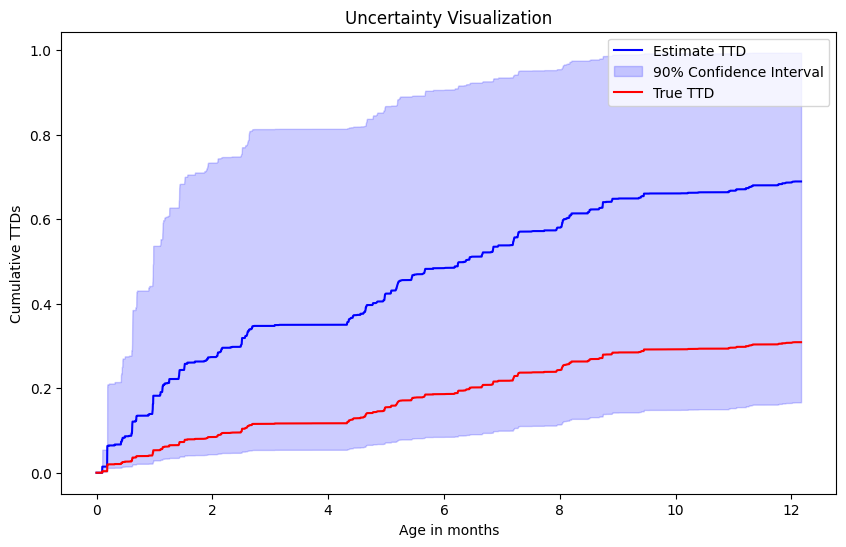

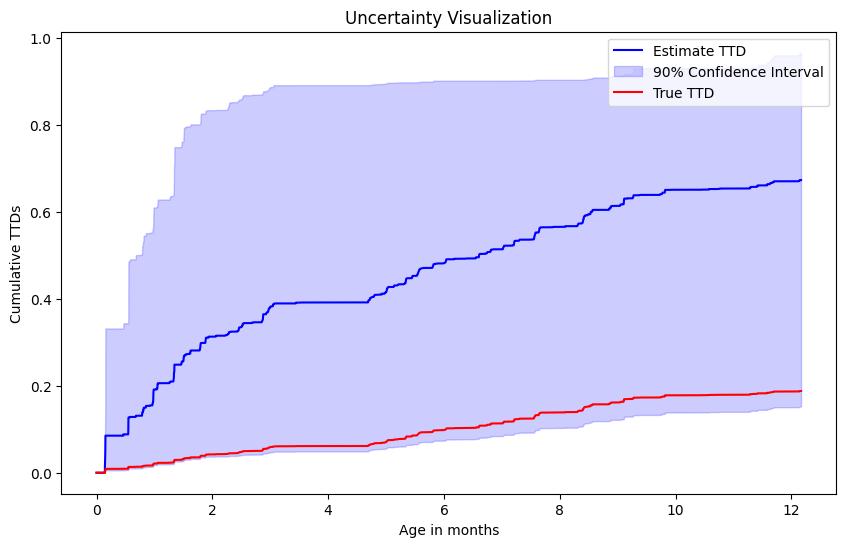

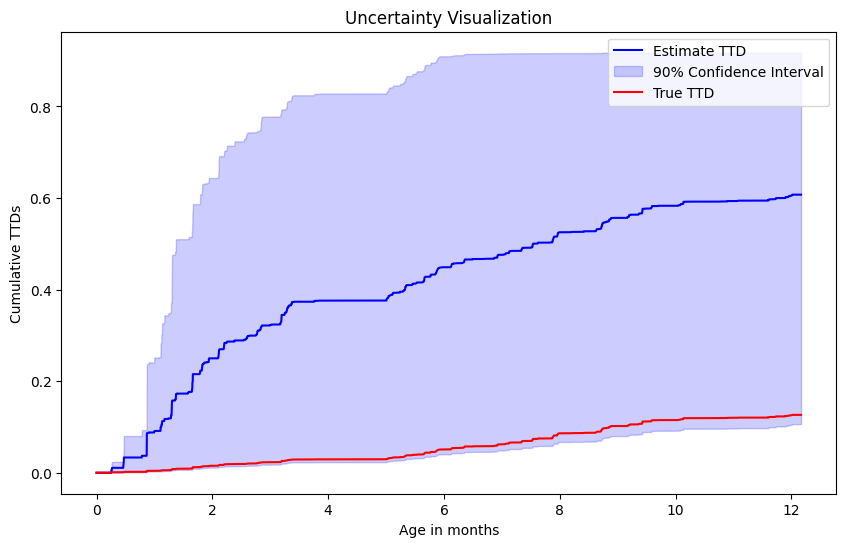

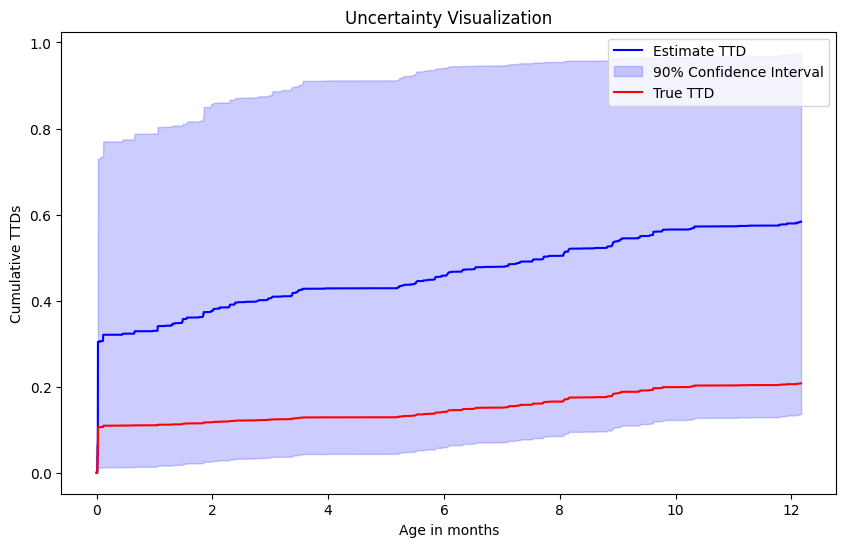

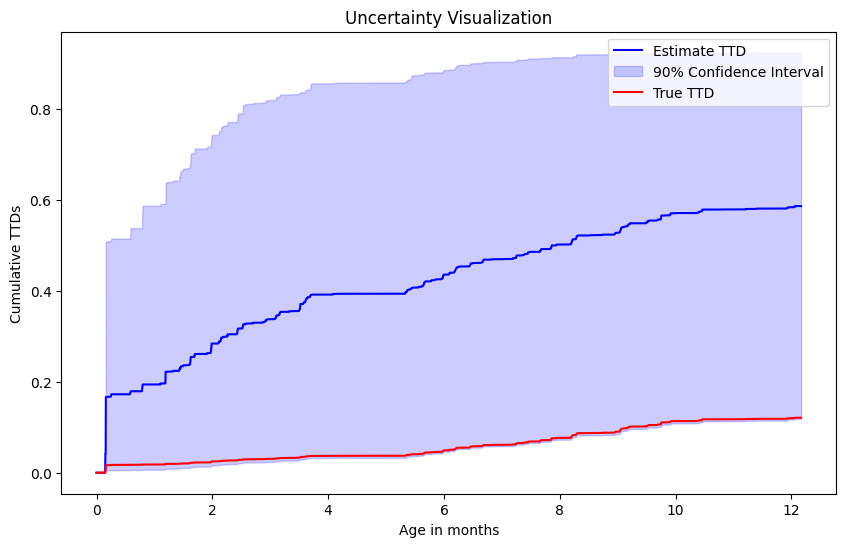

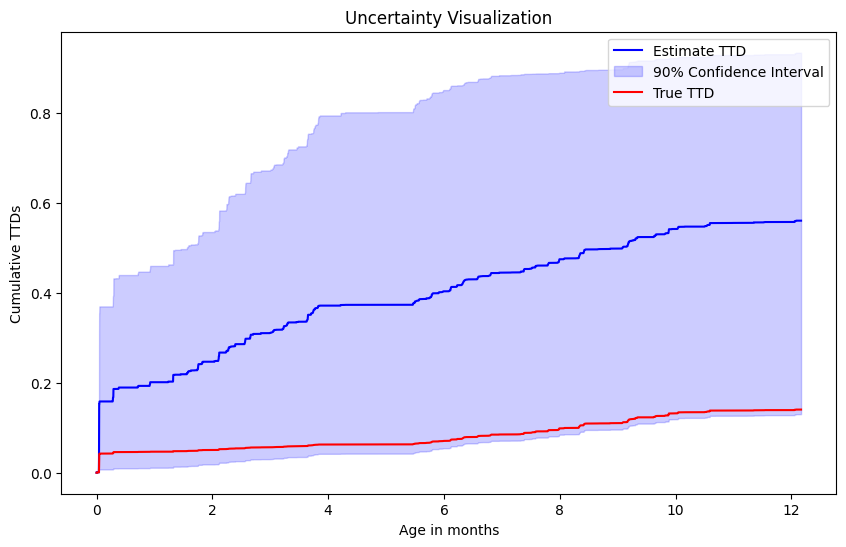

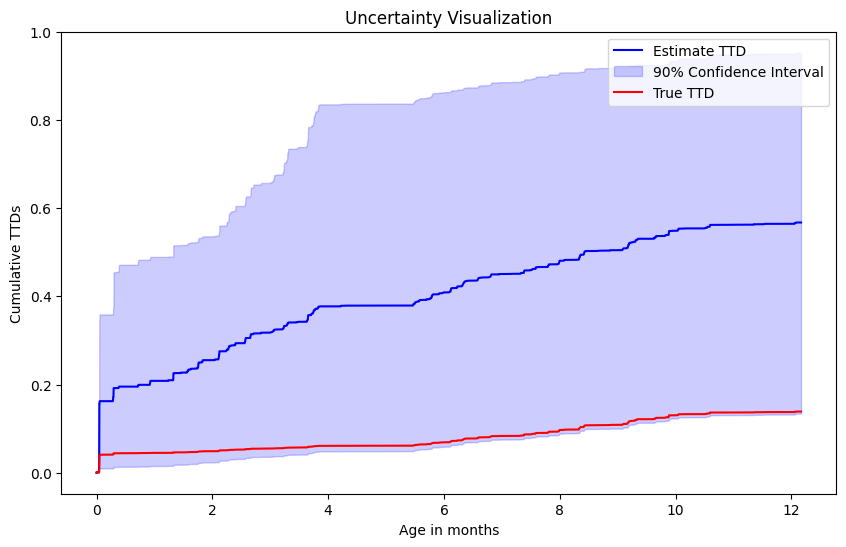

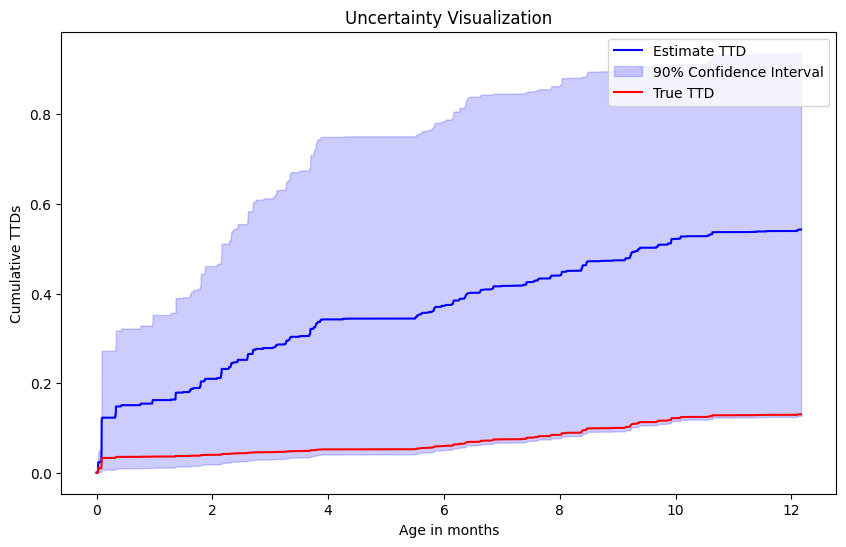

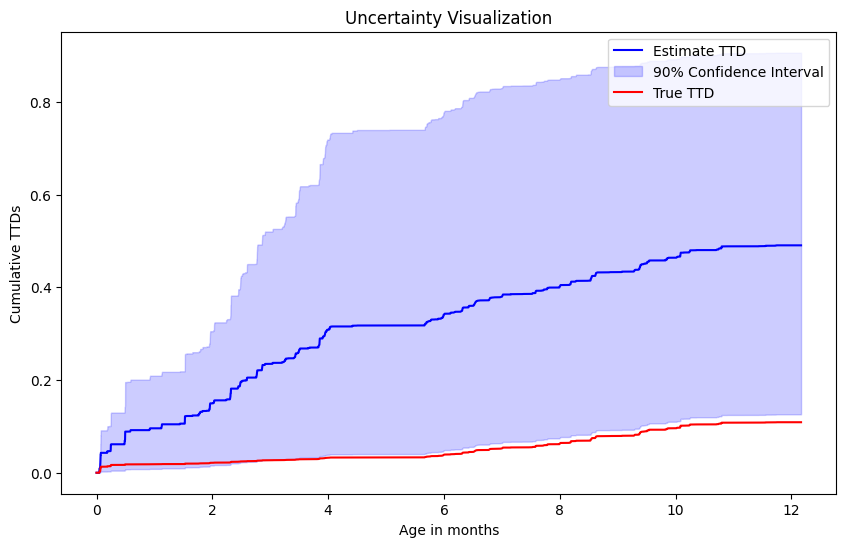

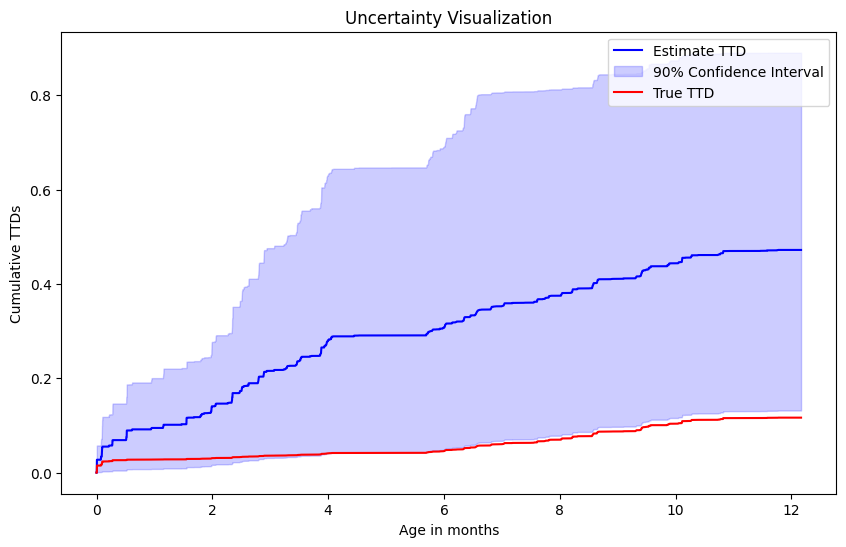

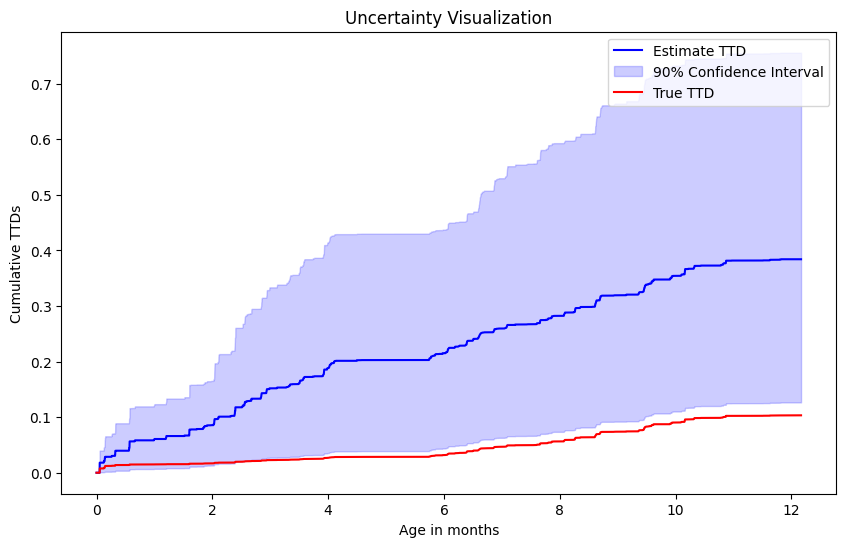

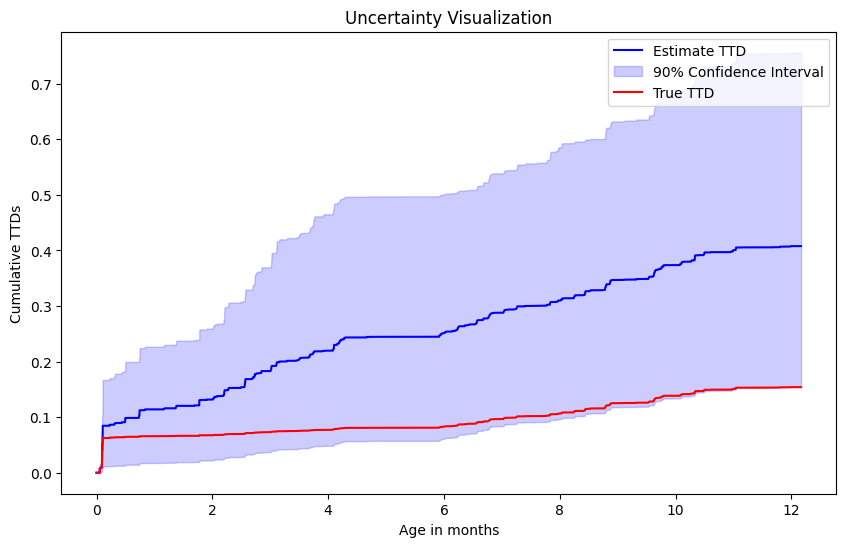

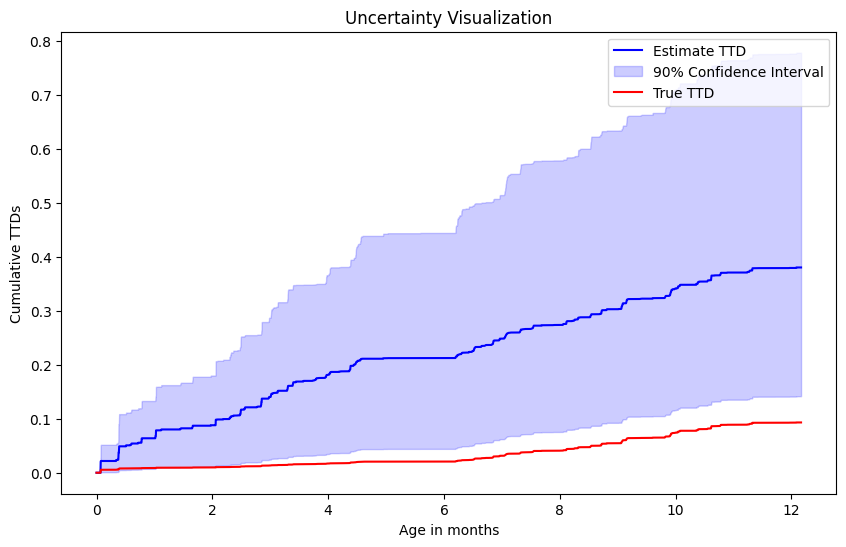

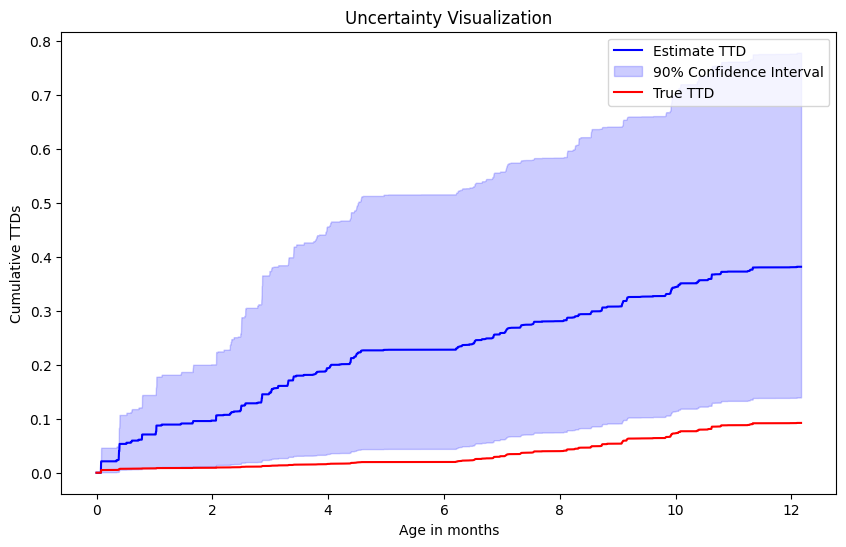

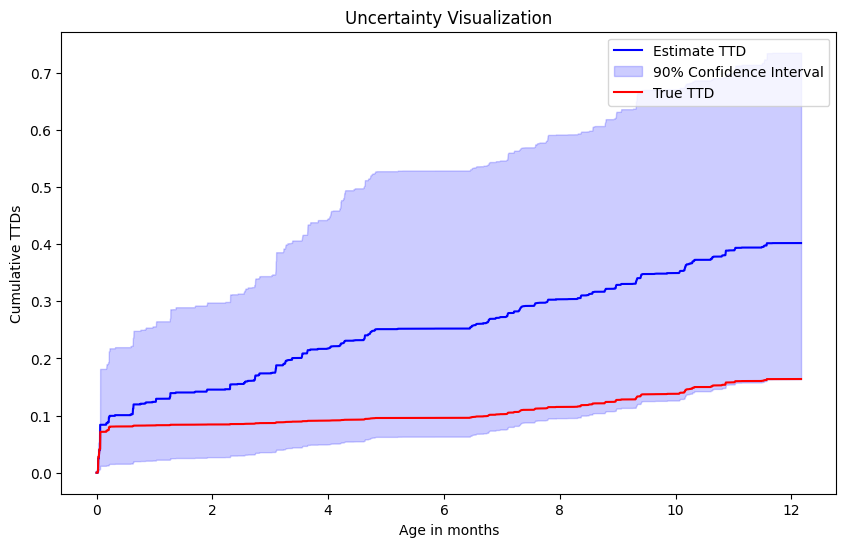

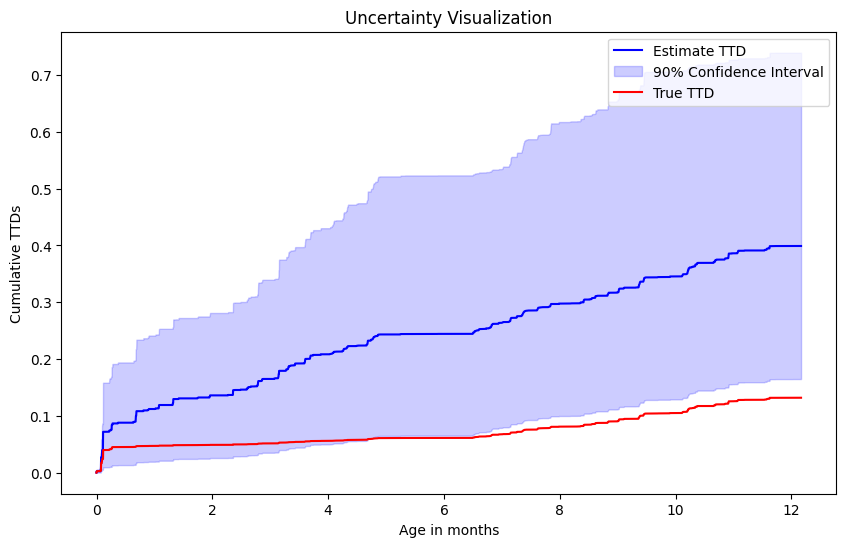

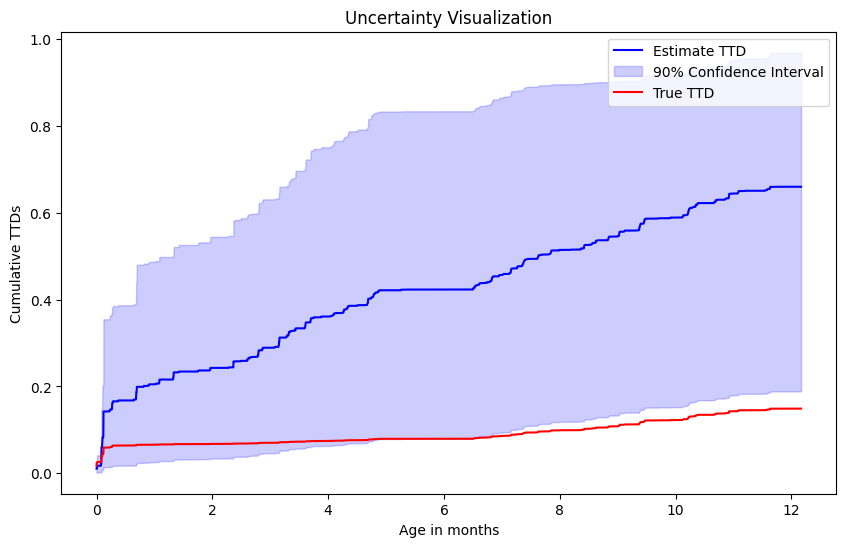

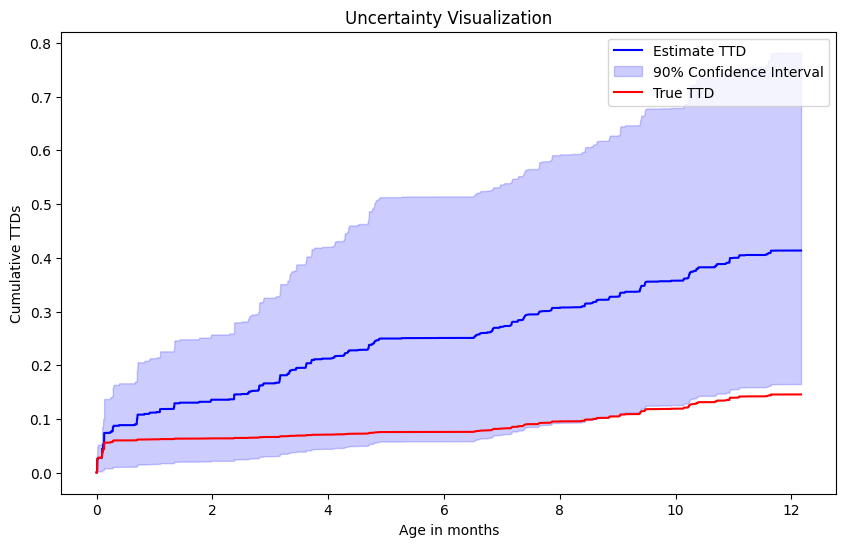

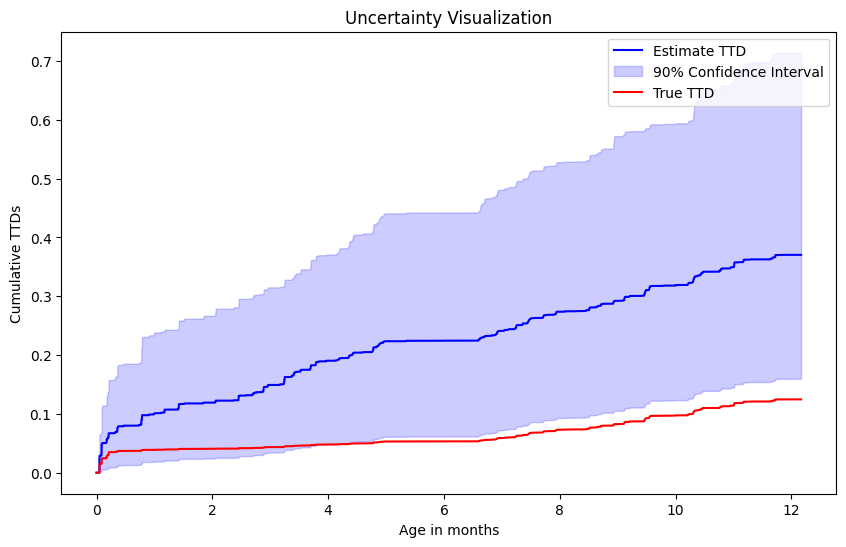

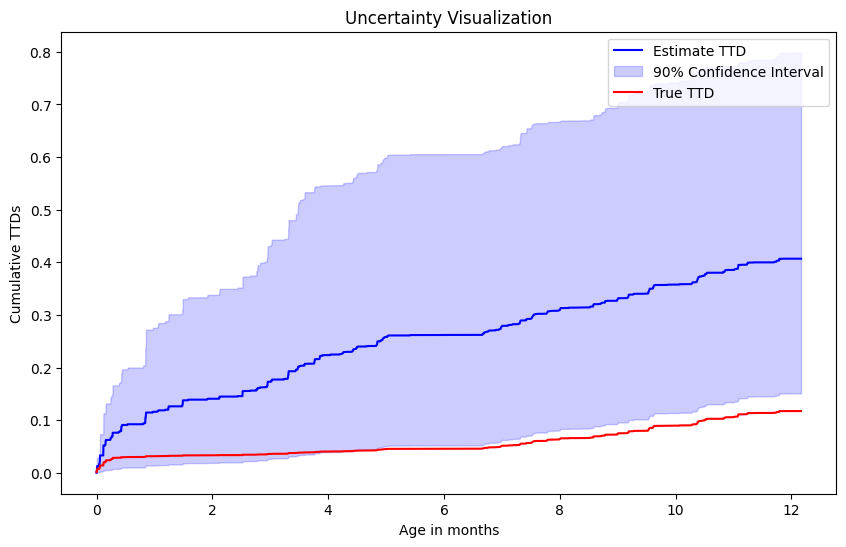

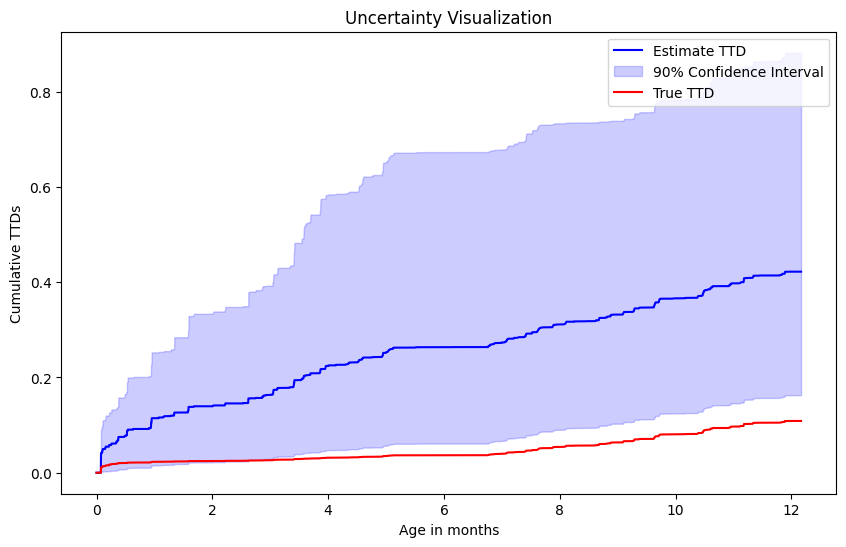

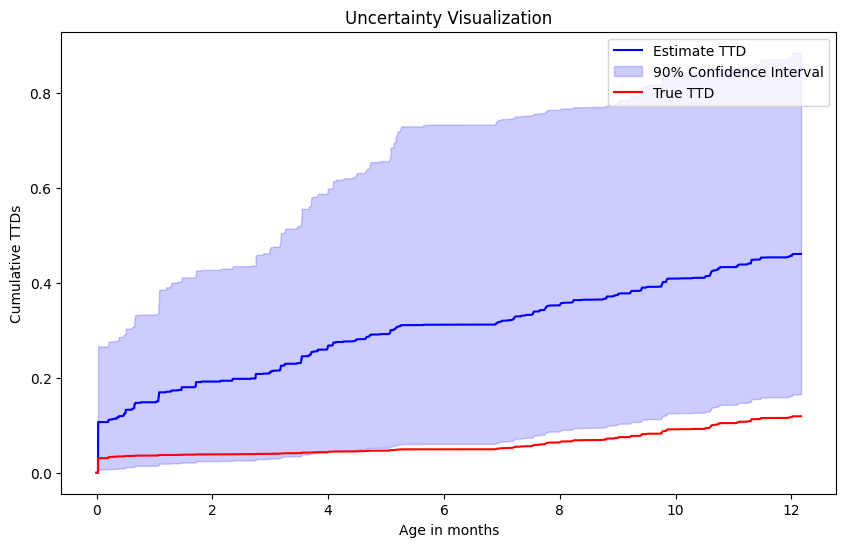

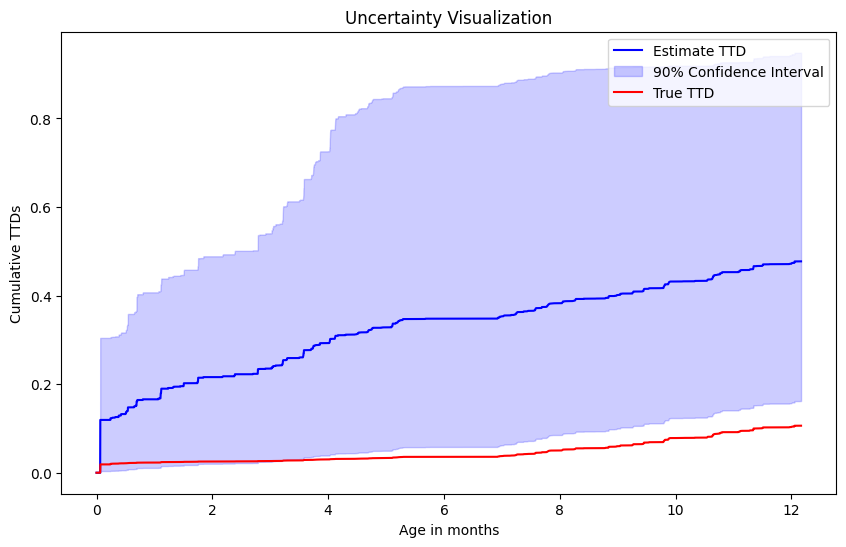

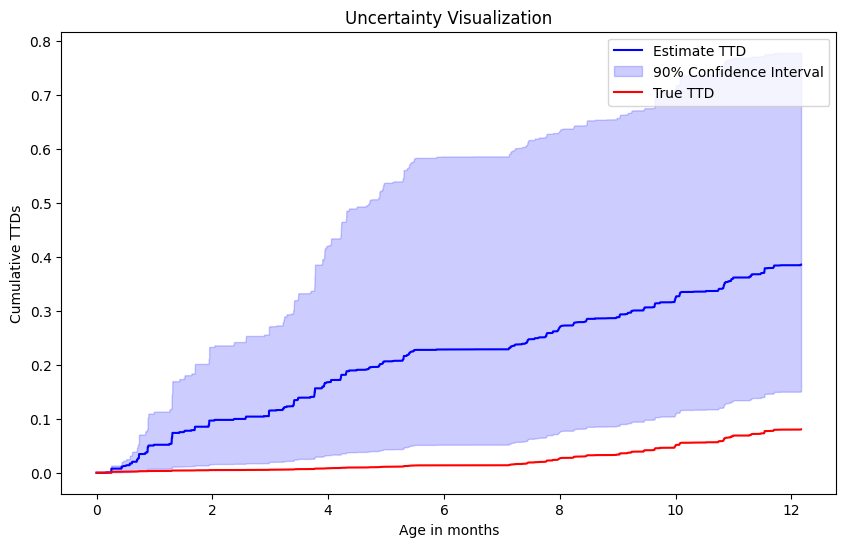

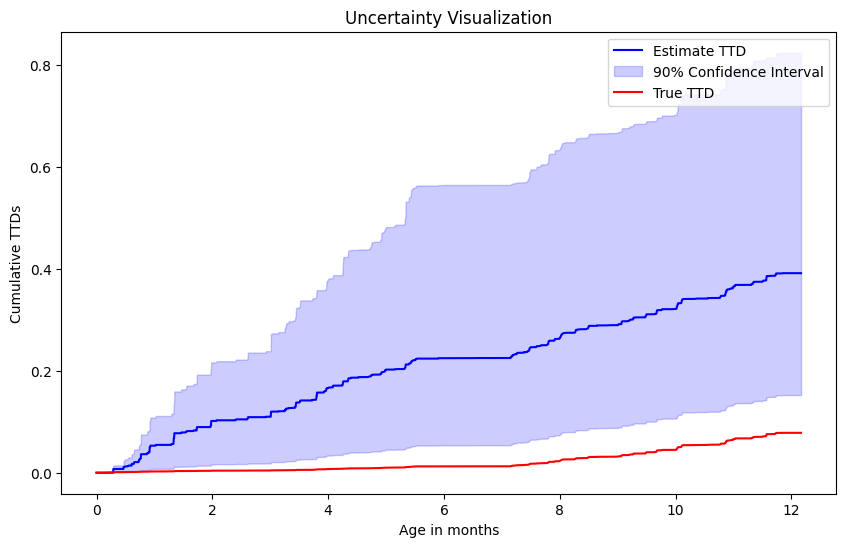

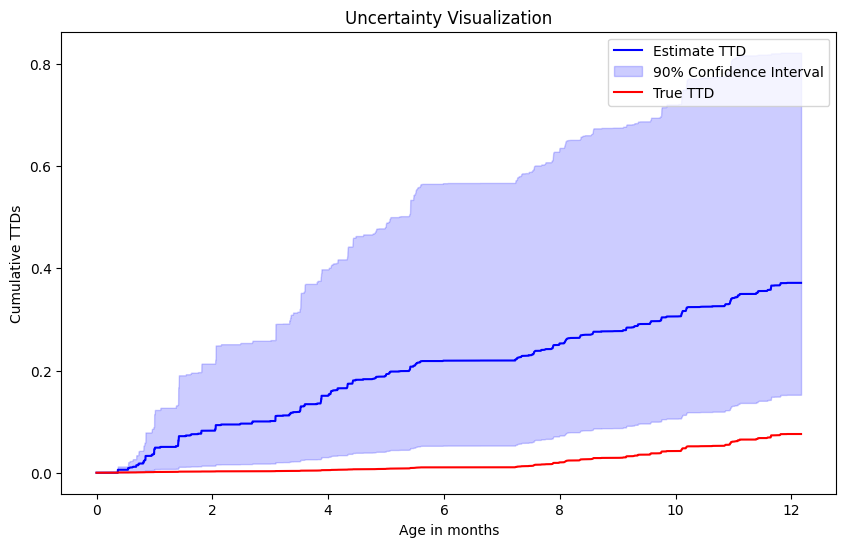

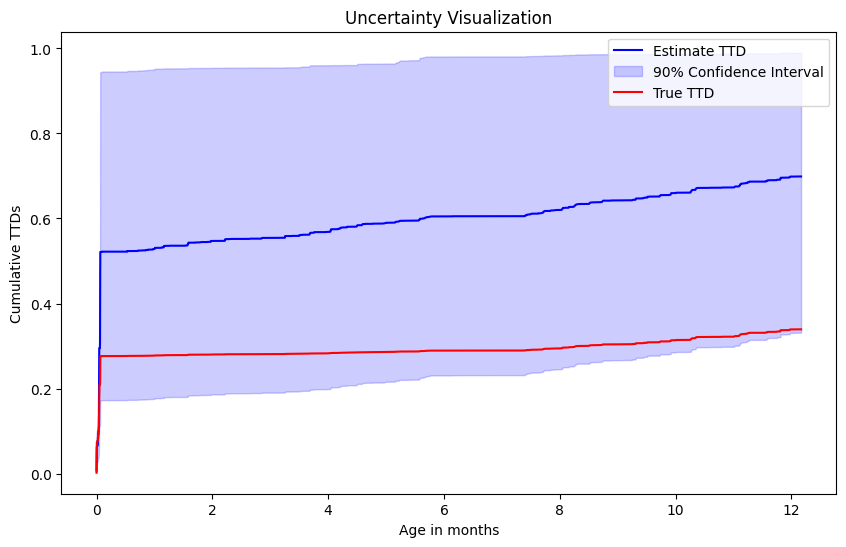

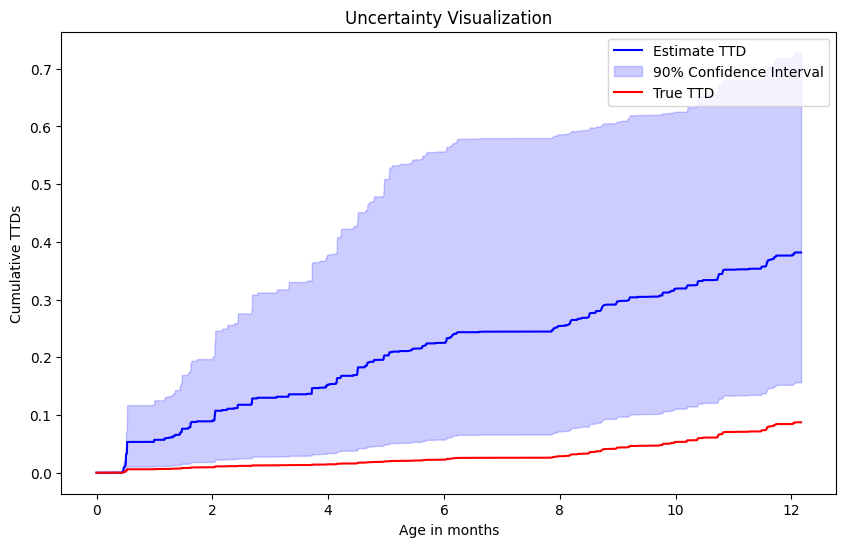

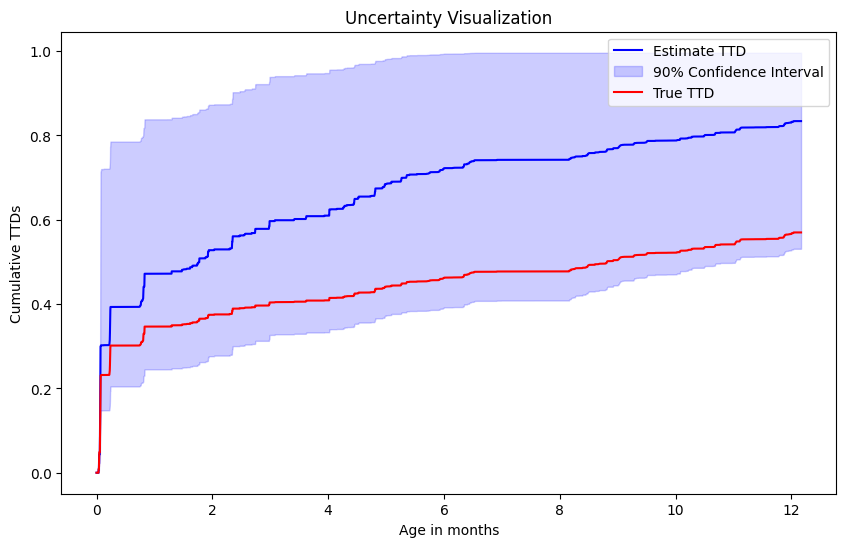

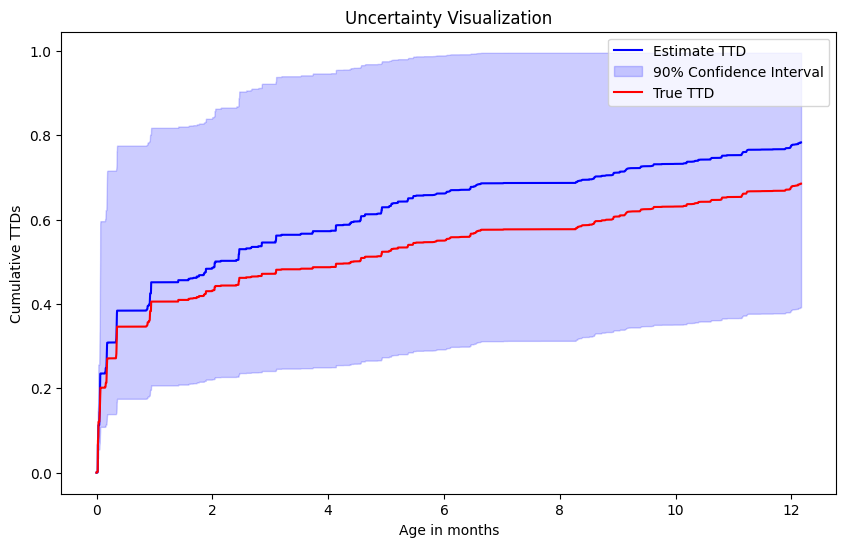

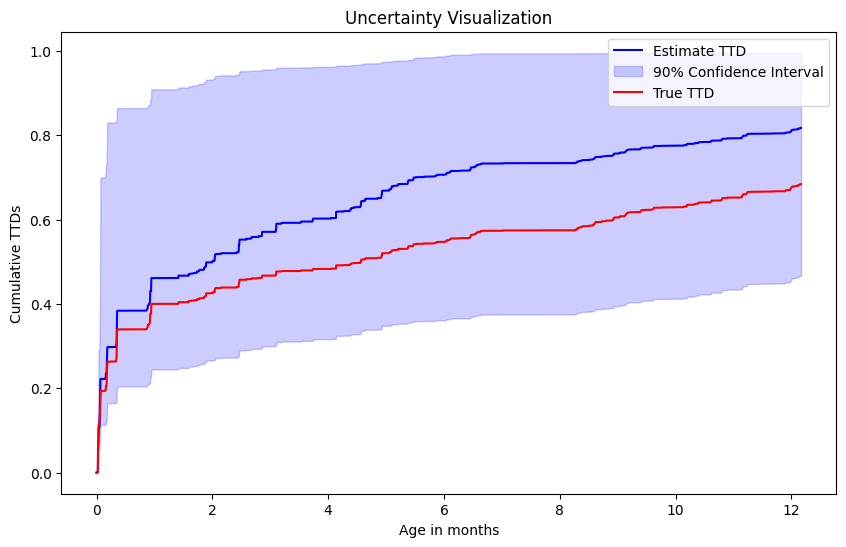

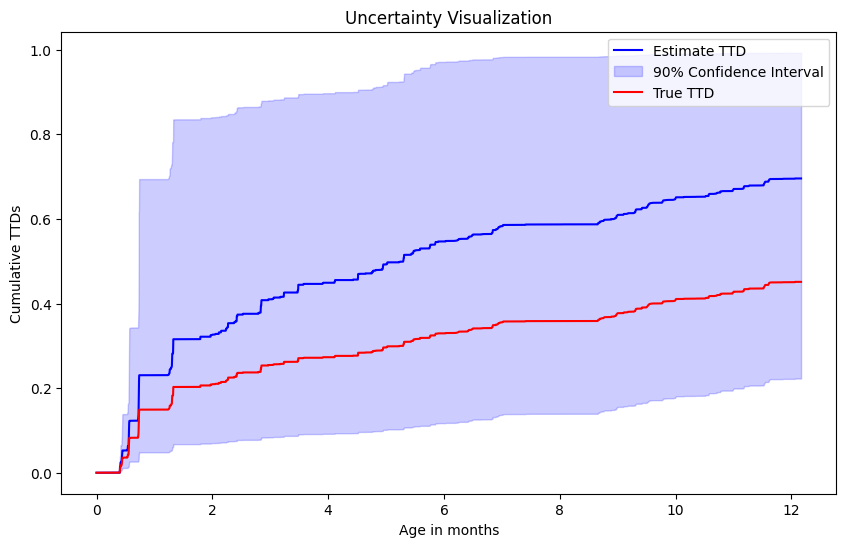

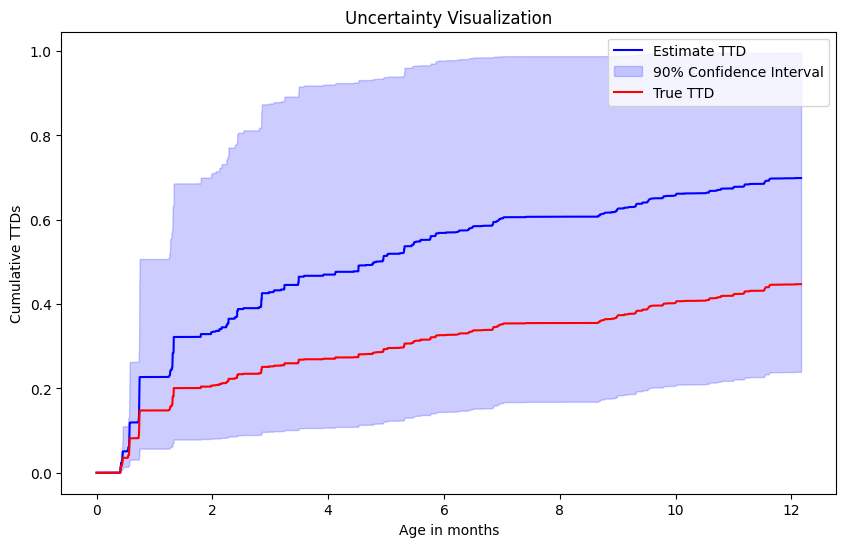

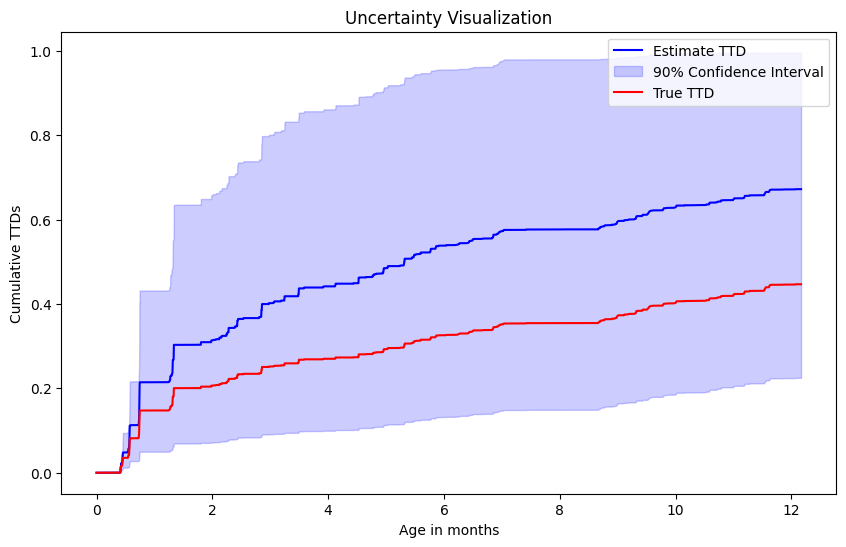

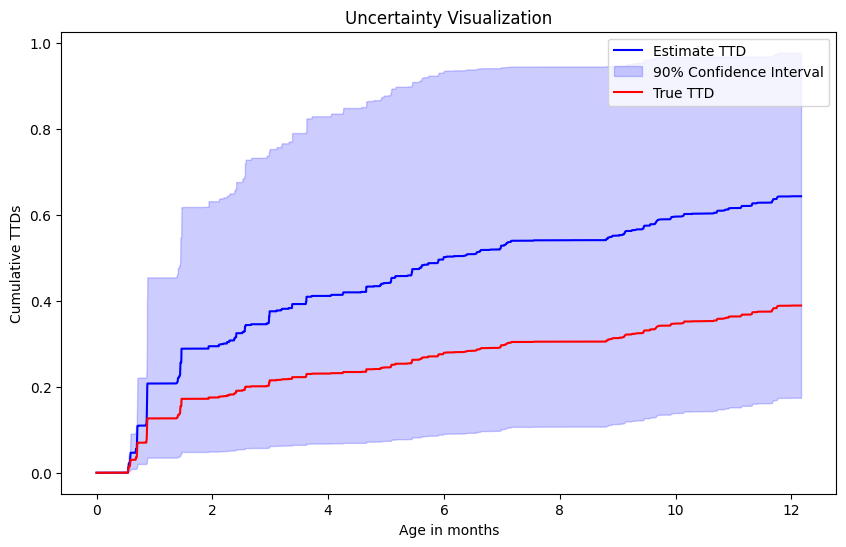

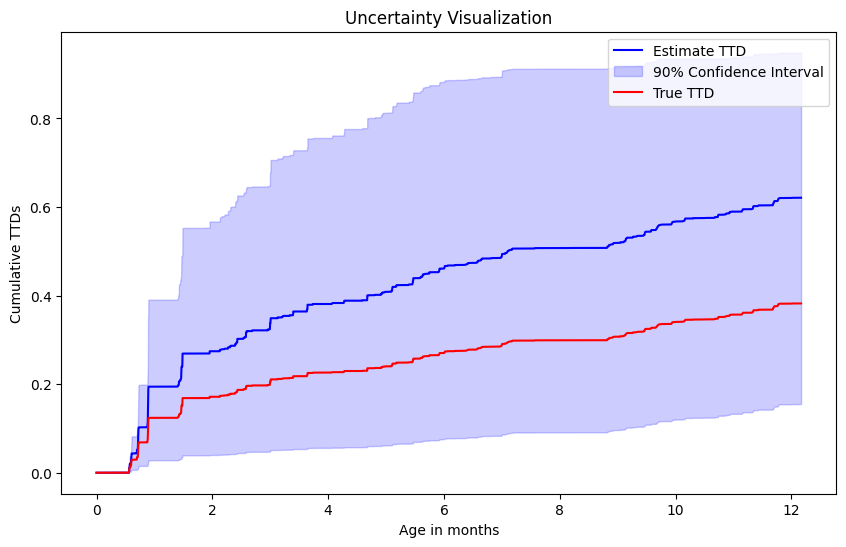

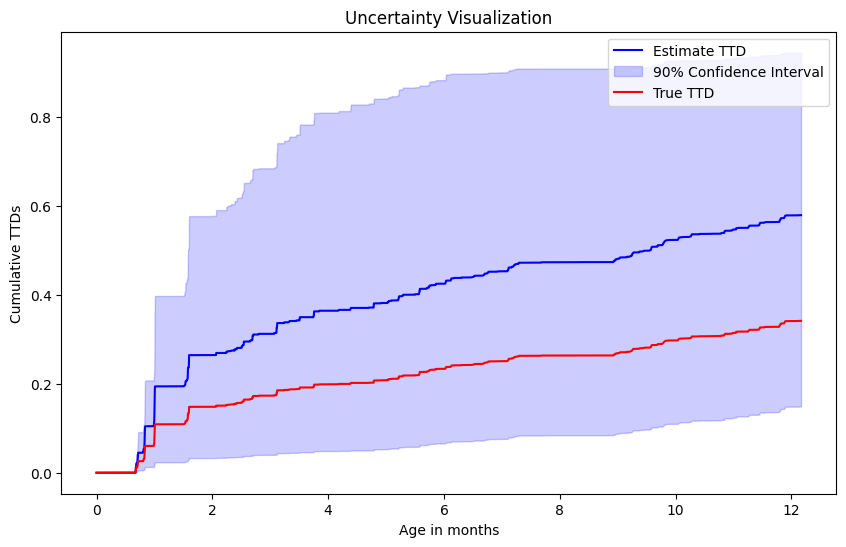

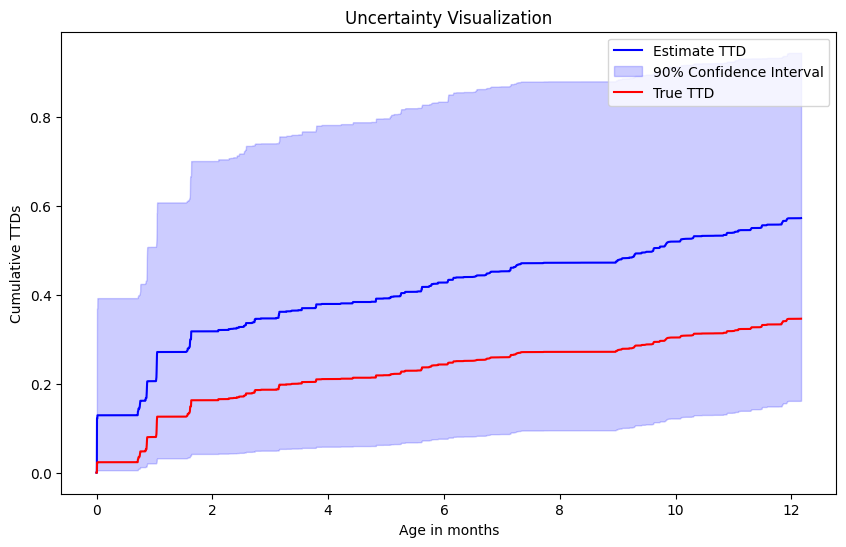

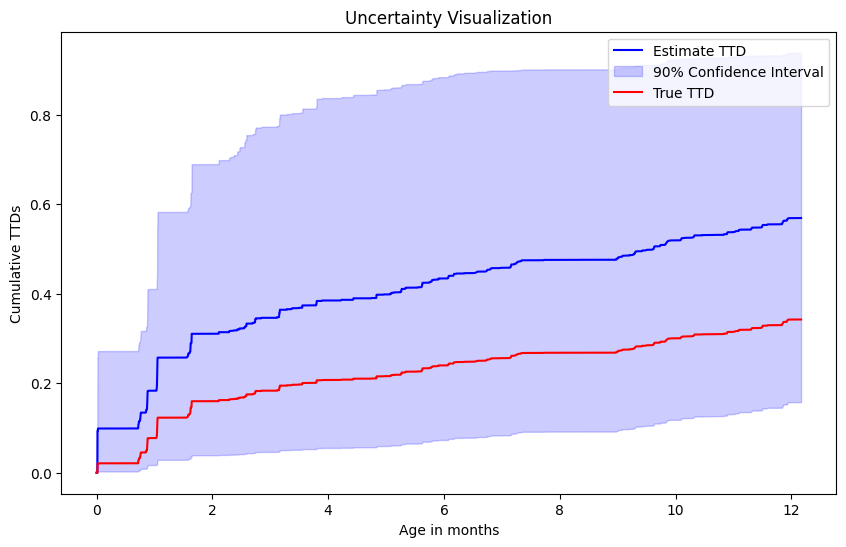

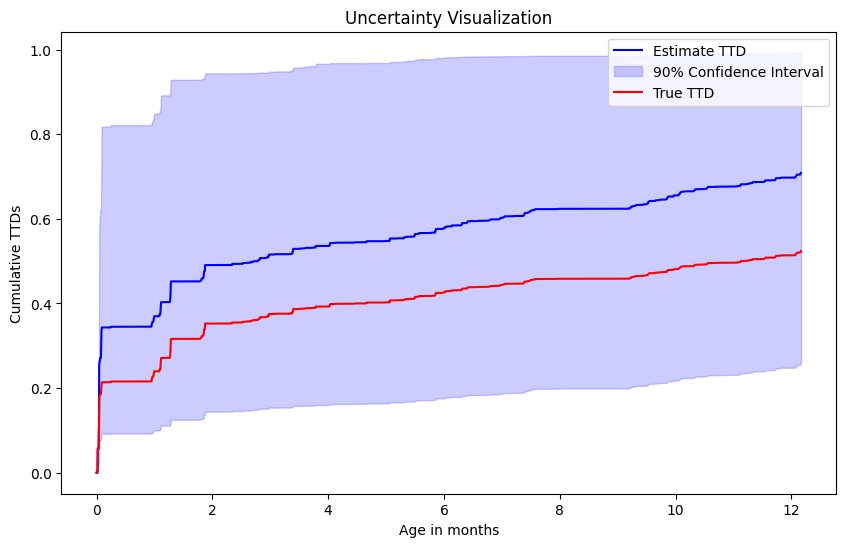

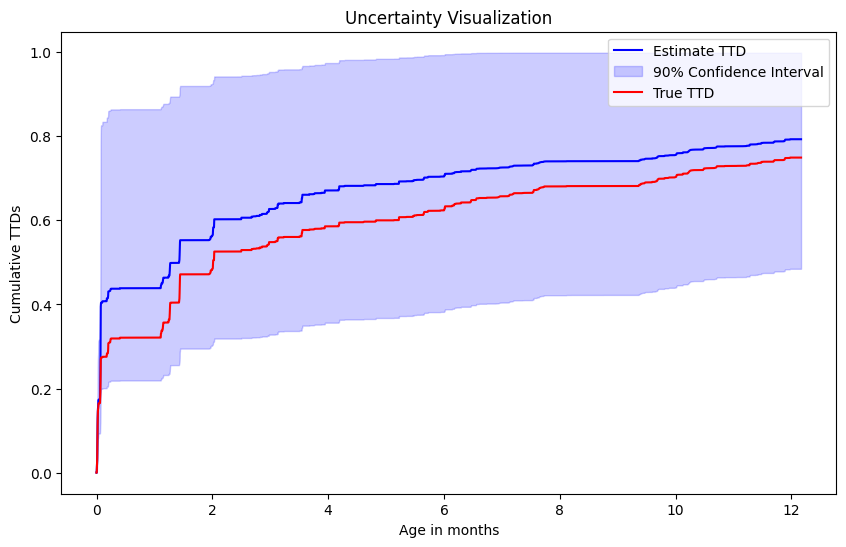

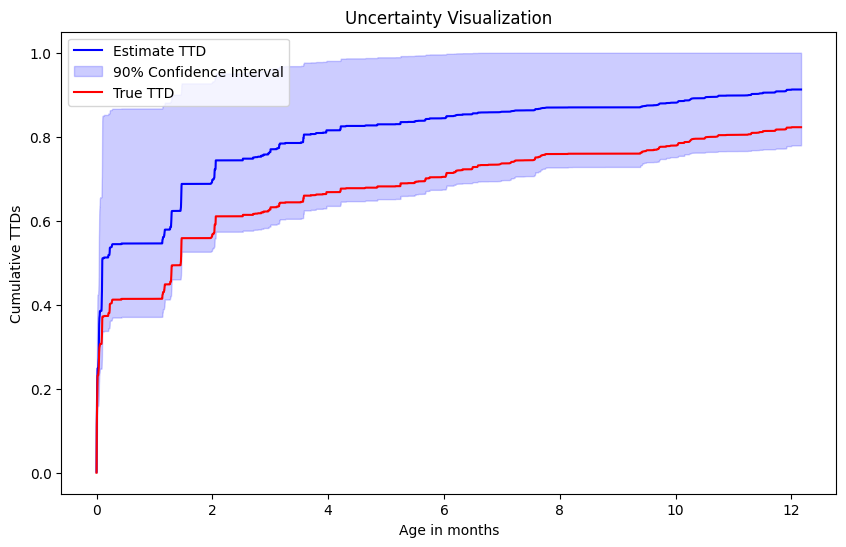

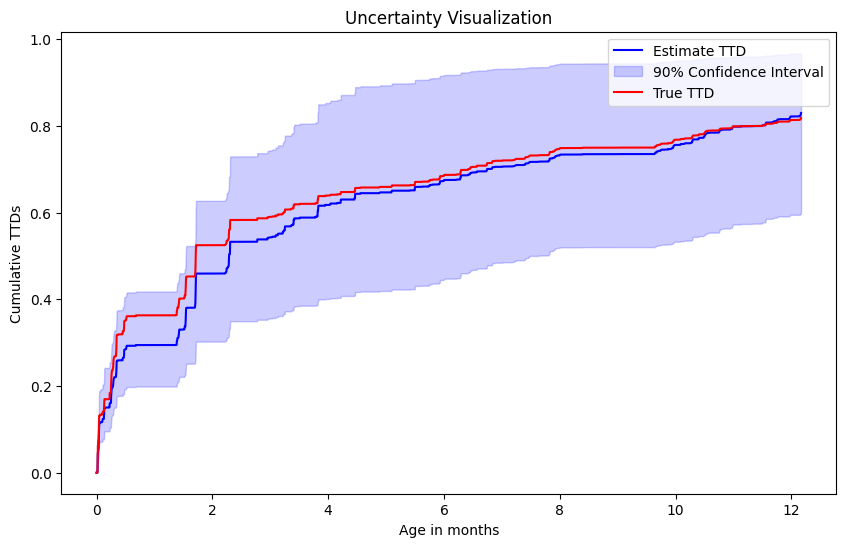

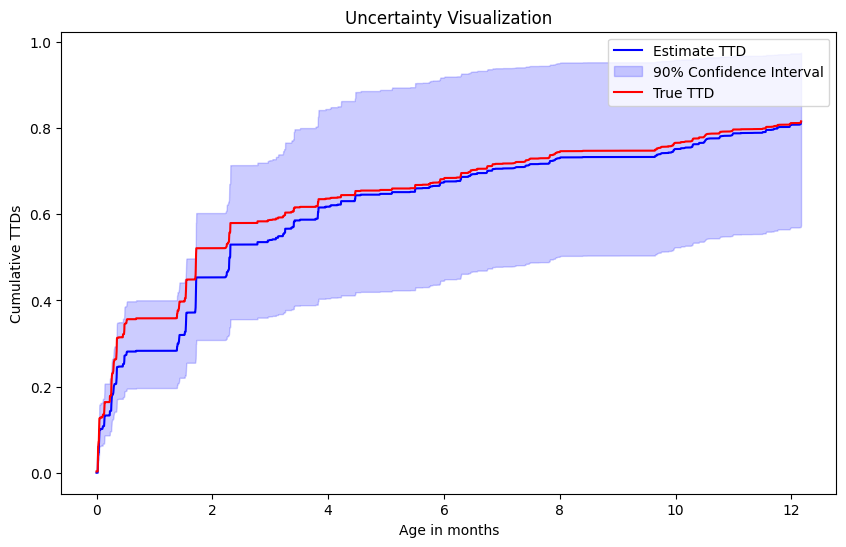

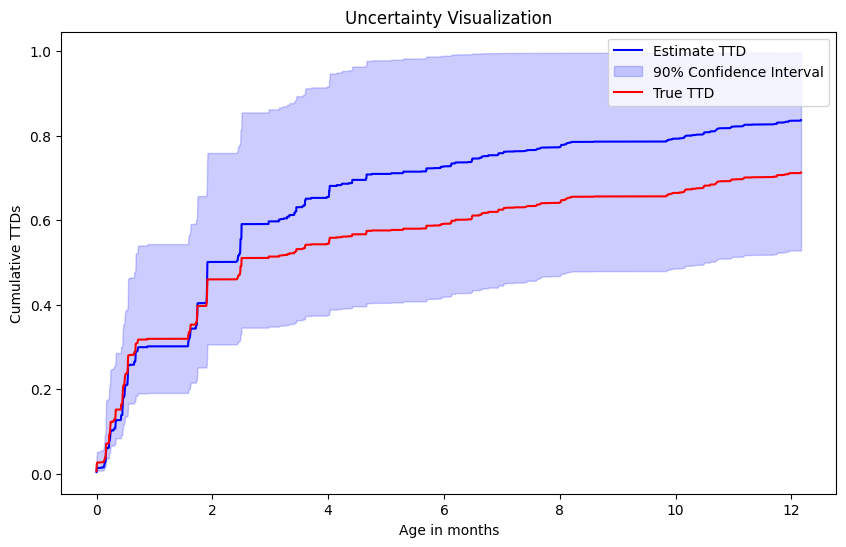

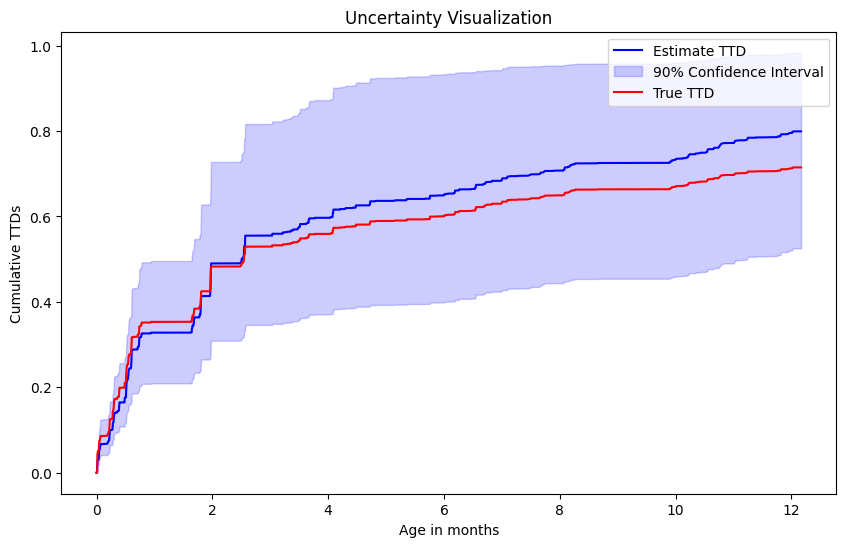

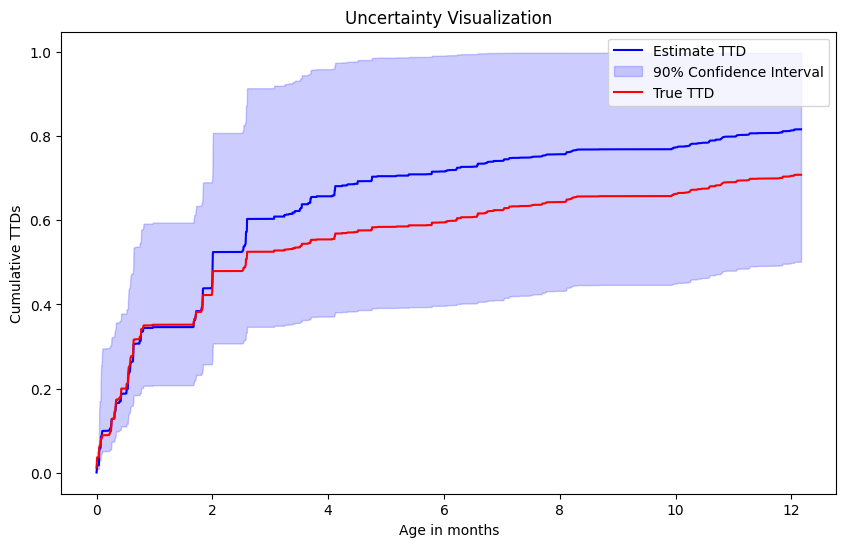

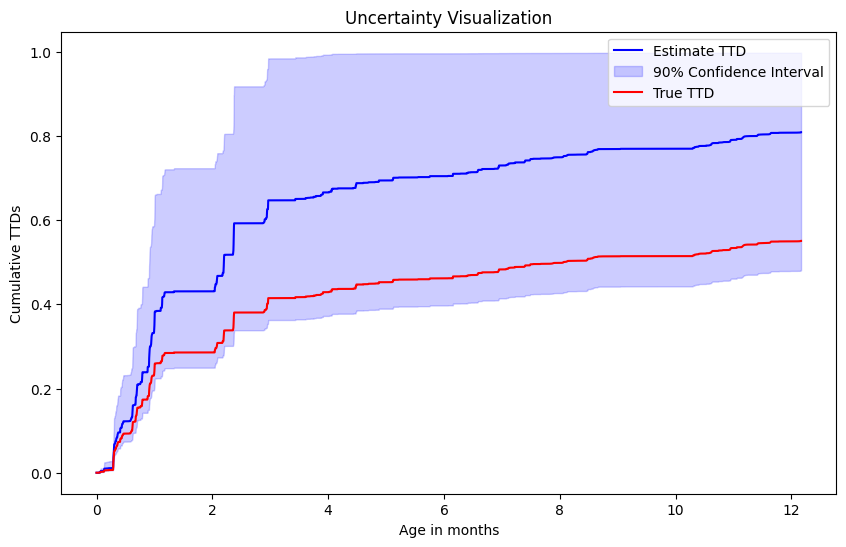

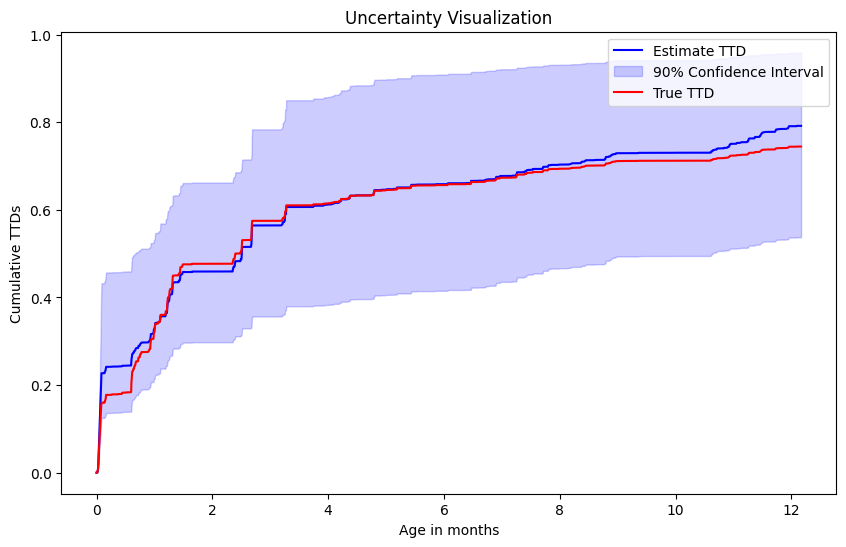

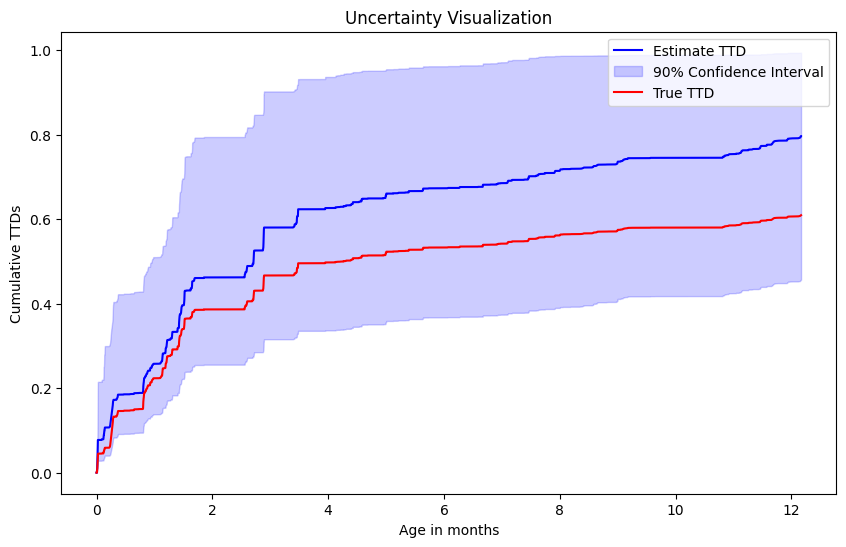

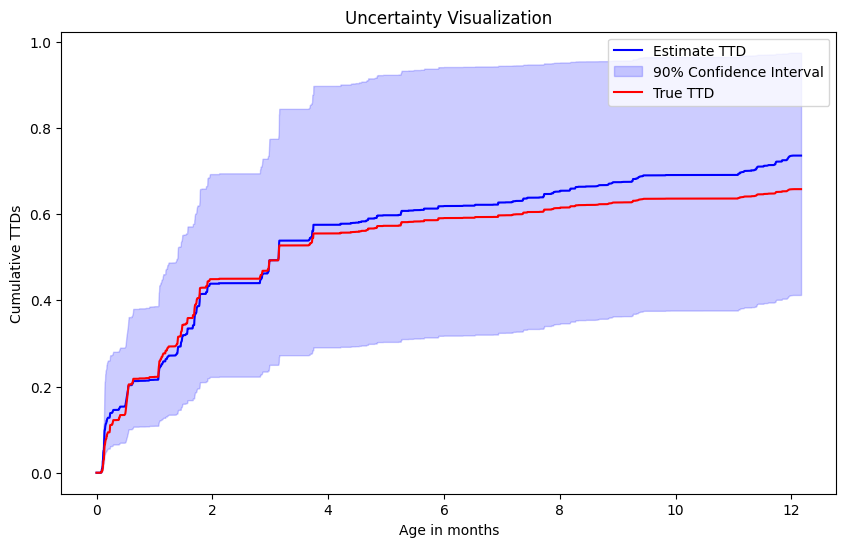

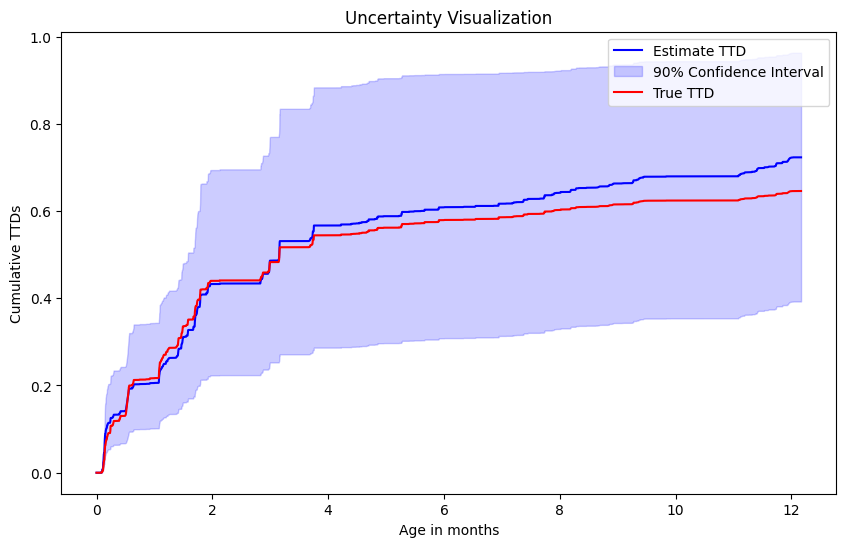

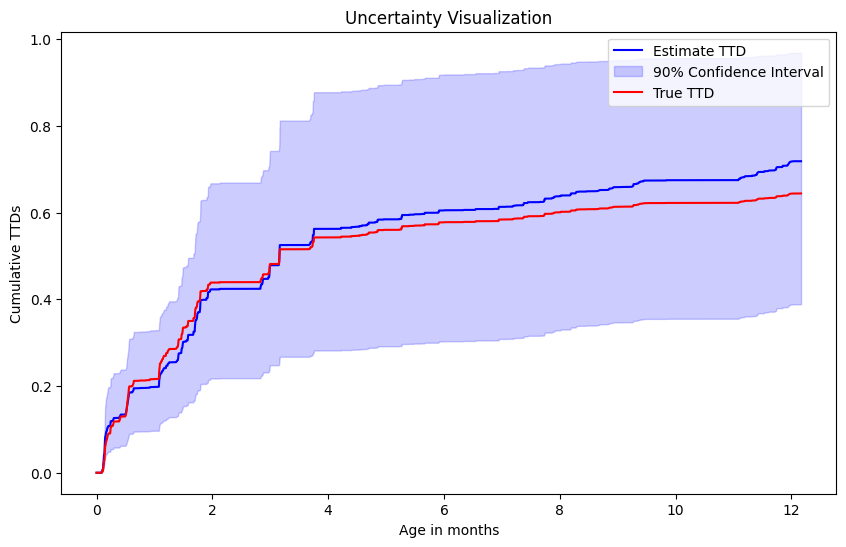

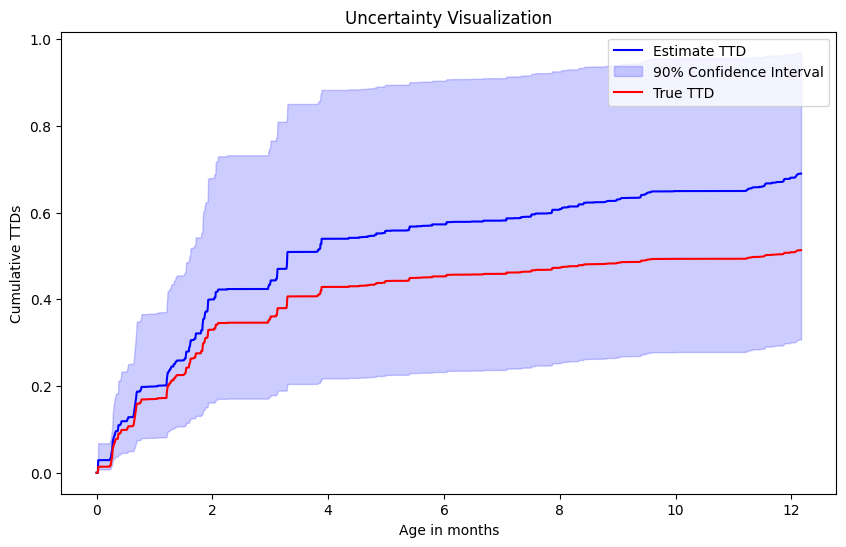

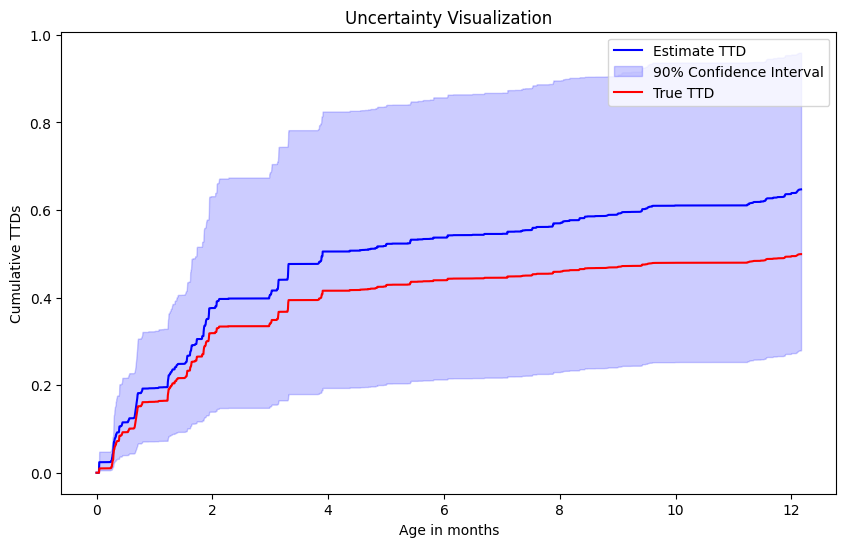

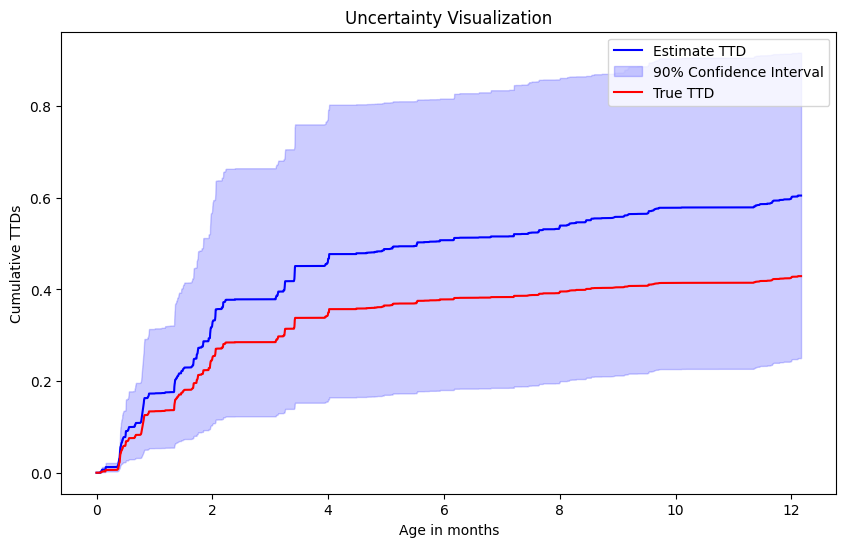

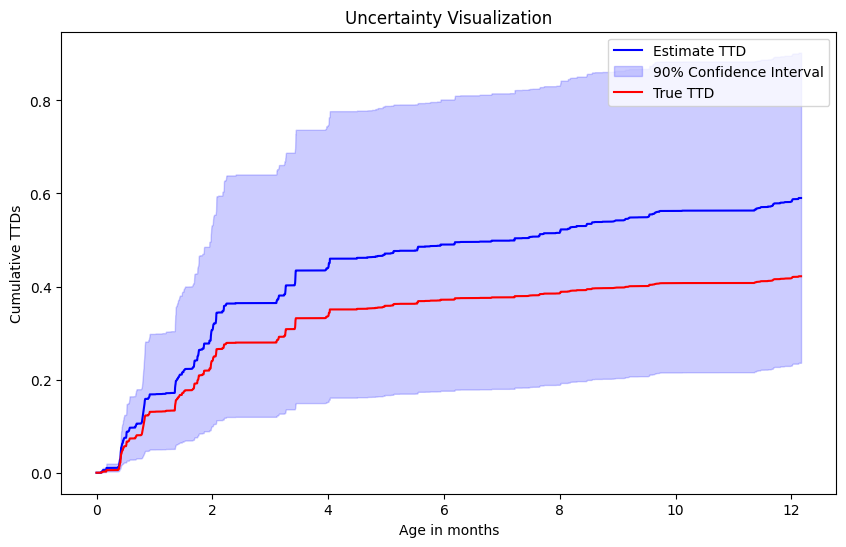

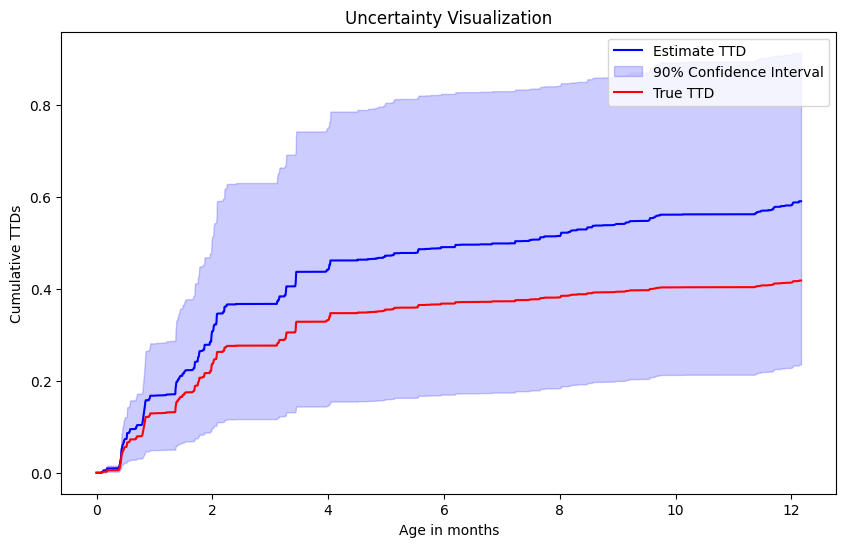

In [15]:
# Plotting
maxT = 365*24
pQ = np.mean(pQ_saved, axis=0)
for i in range(99):
    plt.figure(figsize=(10, 6))
    x = np.arange(maxT)/(24*30)
    estimate = np.cumsum(pQ[i,:maxT])
    plt.plot(x, estimate, label='Estimate TTD', color='blue')
    if True:
        # Parameters
        interval_size = 90
        best_interval = None
        max_deviation = -float('inf')
        best_mean_curve = None

        sampled_functions = np.cumsum(pQ_saved[:,i,:maxT], axis=1)
        
        # Loop through all valid intervals
        for start in range(100-interval_size+1):
            percentile_low = np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), start, axis=0)
            percentile_high = np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), interval_size+start, axis=0)
            
            # Compute deviation using Mean Squared Error (MSE)
            deviation = np.min( [np.sum(estimate-percentile_low) , np.sum(percentile_high-estimate) ])
            
            # Update if this interval is better
            if max_deviation < deviation:
                max_deviation = deviation
                best_interval = (start, start + interval_size)
    if False:
        percentile_5 = np.percentile(pQ_uncertainty[:,i,:maxT], 0, axis=0)
        percentile_95 = np.percentile(pQ_uncertainty[:,i,:maxT], 90, axis=0)
        plt.fill_between(x, np.cumsum(percentile_5), np.cumsum(percentile_95), color='blue', alpha=0.2, label='90% Confidence Interval')

    percentile_5 = np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), best_interval[0], axis=0)
    percentile_95 = np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), best_interval[1], axis=0)
    plt.fill_between(x, percentile_5, percentile_95, color='blue', alpha=0.2, label='90% Confidence Interval')
    plt.plot(x, np.cumsum(ttds_true[i,:maxT]), label='True TTD', color='red')
    
    #plt.plot(x, np.cumsum(np.mean(pQ_uncertainty[:,i,:maxT].numpy(), axis=0)), label='Mean Function', color='cyan')

    plt.title("Uncertainty Visualization")
    plt.xlabel("Age in months")
    plt.ylabel("Cumulative TTDs")
    plt.legend()
    plt.show()

# Mean uncertainty

In [1]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from tqdm import tqdm

site = 'Pully_small_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian3' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
path_model = os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_no_c_{algo}.pth.tar')

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 100
maxT = 365*24

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, [lst_test[0]], BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]

if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian3':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian3(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

n_samples = 200
pQ_saved = np.zeros((n_samples,len(lst_test),365*24))
pQ_saved_low = np.zeros((n_samples,365*24))
pQ_saved_up = np.zeros((n_samples,365*24))

CQ_saved = np.zeros((n_samples,len(lst_test)))

ngroups = int(BATCH_SIZE/10)
for k in tqdm(range(ngroups)):
    indexes = np.array([i for i in range(k*int(BATCH_SIZE/ngroups),(k+1)*int(BATCH_SIZE/ngroups))]).astype(int)
    lst_test_temp = lst_test[indexes]
    with torch.no_grad():            
        Cout_test = torch.zeros(len(lst_test_temp))
        CJ_test = torch.zeros((len(lst_test_temp), Tmax))
        J_test = torch.zeros((len(lst_test_temp), Tmax))

        data_test, timeyear_test = WT.get_data_noBERT(pathsite, site,lst_test_temp, BATCH_SIZE=len(lst_test_temp))

    
        for i,t in enumerate(lst_test_temp):
            Cout_test[i] = Cout[t]
            CJ_test[i,:] = CJ[t-Tmax:t]
            J_test[i,:] = J[t-Tmax:t]
    
        if algo=='Ispline':
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo=='AgeDomain':
            Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
        elif algo in ['SumSquares_noBERT2_bayesian3']:
            Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
            w = model.model.forward_w(data_test)
            w = w.detach().numpy()
            frac_year = timeyear_test
            frac_year = [el-int(el) for el in frac_year]
            frac_year = np.array([min([1-el, el]) for el in frac_year])
            winter_idxs = np.where(frac_year<=(2*30/365))[0]
            summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
            w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
            w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)
    
            Chat_uncertainty, pQ_uncertainty = WT.get_uncertainties(data_test, J_test, CJ_test, n_samples=n_samples)
            CQ_saved[:,indexes] = Chat_uncertainty
    
            start_index = (WT.path_model).find("BERT4TRANSIT")
            name_model = WT.path_model[start_index:-8] # -8 to remove '.pth.tar'

            pQ_saved[:,indexes,:] = pQ_uncertainty[:,:,:pQ_saved.shape[-1]]
    
if False:
    pQ_uncertainty = np.mean(pQ_saved, axis=1)
    filename = os.path.join(pathsite, 'save', "pQ_uncertainties_{0}.npy".format(site))    
    np.save(filename, pQ_uncertainty)
elif False:
    pQlow = np.zeros(pQ_saved.shape[2])
    pQup = np.zeros(pQ_saved.shape[2])
    for i in range(pQ_saved.shape[1]):
        pQlow += np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), 5, axis=0) / pQ_saved.shape[1]
        pQup += np.percentile(np.cumsum(pQ_saved[:,i,:maxT], axis=1), 95, axis=0) / pQ_saved.shape[1]
else:
    pQlow = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 5, axis=0)
    pQup = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 95, axis=0)

  0% 0/10 [00:00<?, ?it/s]/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 10% 1/10 [00:19<02:52, 19.13s/it]/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 20% 2/10 [00:39<02:36, 19.57s/it]/myhome/mambaforge/envs/watres_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/myhome/mambaforge

In [5]:
rows_to_load = lst_test - (len(CJ)-365*24*2)
npy_file = os.path.join(pathsite_ground_truth, 'TTD.npy')
ttds = np.load(npy_file)
# keeping relevant ground truth values
idxs2keep_true_ttd = lst_test - (len(CJ)-ttds.shape[0])
ttds_true = ttds[idxs2keep_true_ttd,:]
ywf_true = np.cumsum(ttds_true, axis=1)[:,[24*30*j for j in range(1,10)]]
print('True TTDs loaded')

True TTDs loaded


In [3]:
pQlow = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 0, axis=0)
pQup = np.percentile(np.cumsum( np.mean(pQ_saved[:,:,:maxT], axis=1), axis=1), 100, axis=0)

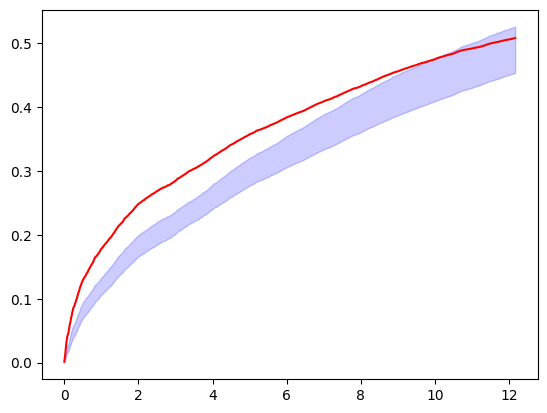

In [6]:
x = np.arange(maxT)/(24*30)
plt.fill_between(x, pQlow, pQup, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(x, np.cumsum(np.mean(ttds_true[:,:maxT], axis=0)), label='True TTD', color='red')

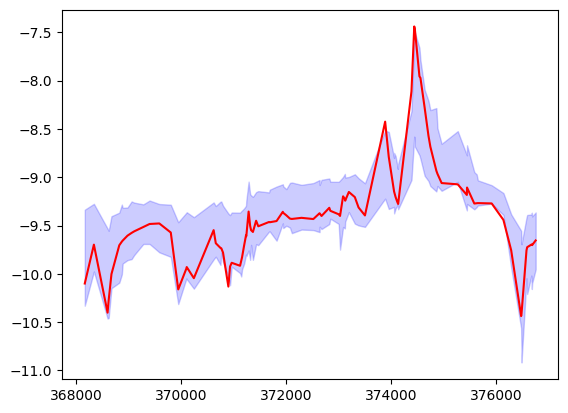

In [2]:
Cout_test = Cout[lst_test]
CQlow = np.percentile(CQ_saved, 2.5, axis=0)
CQup = np.percentile(CQ_saved, 97.5, axis=0)
plt.fill_between(lst_test, CQlow, CQup, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(lst_test, Cout_test, label='Observed tracer', color='red')

In [7]:
start_index = WT.path_model.find("BERT4TRANSIT")
name_model = WT.path_model[start_index:-8]
filename = os.path.join(WT.pathsite, 'save', f"params_uncertainties_{name_model}.pkl")

with open(filename, 'rb') as handle:
    params_svi = pickle.load(handle)

for key, value in params_svi.items():
    params_svi[key] = torch.tensor(value)

In [8]:
params_svi

{'gumbel': tensor([1.5883e+00, 8.5771e-02, 7.8708e-03, 1.3632e-03, 3.7525e-04, 9.1023e-05,
         3.4162e-05, 2.7146e-05, 2.4913e-05, 2.4147e-05, 2.4530e-05, 2.7508e-05,
         2.6909e-05, 2.2240e-05]),
 'sigma': tensor(0.2972)}

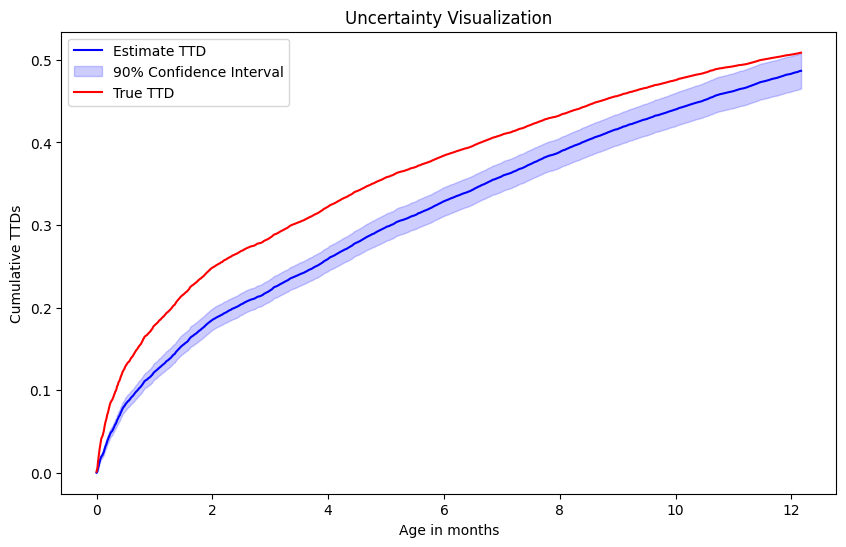

In [8]:
plt.figure(figsize=(10, 6))
x = np.arange(maxT)/(24*30)
estimate = np.cumsum(np.mean(pQ_uncertainty, axis=0))
plt.plot(x, estimate, label='Estimate TTD', color='blue')
if True:
    # Parameters
    interval_size = 95
    best_interval = None
    max_deviation = -float('inf')
    best_mean_curve = None

    sampled_functions = np.cumsum(pQ_uncertainty[:,:maxT], axis=1)
    
    # Loop through all valid intervals
    for start in range(100-interval_size+1):
        percentile_low = np.percentile(np.cumsum(pQ_uncertainty[:,:maxT], axis=1), start, axis=0)
        percentile_high = np.percentile(np.cumsum(pQ_uncertainty[:,:maxT], axis=1), interval_size+start, axis=0)
        
        # Compute deviation using Mean Squared Error (MSE)
        deviation = np.min( [np.sum(estimate-percentile_low) , np.sum(percentile_high-estimate) ])
        
        # Update if this interval is better
        if max_deviation < deviation:
            max_deviation = deviation
            best_interval = (start, start + interval_size)

percentile_5 = np.percentile(np.cumsum(pQ_uncertainty[:,:maxT], axis=1), best_interval[0], axis=0)
percentile_95 = np.percentile(np.cumsum(pQ_uncertainty[:,:maxT], axis=1), best_interval[1], axis=0)
plt.fill_between(x, percentile_5, percentile_95, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(x, np.cumsum(np.mean(ttds_true[:,:maxT], axis=0)), label='True TTD', color='red')

#plt.plot(x, np.cumsum(np.mean(pQ_uncertainty[:,i,:maxT].numpy(), axis=0)), label='Mean Function', color='cyan')

plt.title("Uncertainty Visualization")
plt.xlabel("Age in months")
plt.ylabel("Cumulative TTDs")
plt.legend()
plt.show()